# Class

> Several classes for estimating statistics and generating plots.

- order: 2

In [3]:
#| default_exp _classes

In [4]:
#| hide
from __future__ import annotations

In [5]:
#| hide
from nbdev.showdoc import *
import nbdev
nbdev.nbdev_export()

In [6]:
#| export
import numpy as np
from scipy.stats import norm
import pandas as pd
from scipy.stats import randint

In [7]:
#| hide
import dabest

In [8]:
#| export
class Dabest(object):

    """
    Class for estimation statistics and plots.
    """

    def __init__(self, data, idx, x, y, paired, id_col, ci, 
                resamples, random_seed, proportional, delta2, 
                experiment, experiment_label, x1_level, mini_meta):

        """
        Parses and stores pandas DataFrames in preparation for estimation
        statistics. You should not be calling this class directly; instead,
        use `dabest.load()` to parse your DataFrame prior to analysis.
        """

        # Import standard data science libraries.
        import numpy as np
        import pandas as pd
        import seaborn as sns

        self.__delta2       = delta2
        self.__experiment   = experiment
        self.__ci           = ci
        self.__data         = data
        self.__id_col       = id_col
        self.__is_paired    = paired
        self.__resamples    = resamples
        self.__random_seed  = random_seed
        self.__proportional = proportional
        self.__mini_meta    = mini_meta 

        # Make a copy of the data, so we don't make alterations to it.
        data_in = data.copy()
        # data_in.reset_index(inplace=True)
        # data_in_index_name = data_in.index.name


        # Check if it is a valid mini_meta case
        if mini_meta is True:

            # Only mini_meta calculation but not proportional and delta-delta function
            if proportional is True:
                err0 = '`proportional` and `mini_meta` cannot be True at the same time.'
                raise ValueError(err0)
            elif delta2 is True:
                err0 = '`delta` and `mini_meta` cannot be True at the same time.'
                raise ValueError(err0)
            
            # Check if the columns stated are valid
            if all([isinstance(i, str) for i in idx]):
                if len(pd.unique([t for t in idx]).tolist())!=2:
                    err0 = '`mini_meta` is True, but `idx` ({})'.format(idx) 
                    err1 = 'does not contain exactly 2 columns.'
                    raise ValueError(err0 + err1)
            elif all([isinstance(i, (tuple, list)) for i in idx]):
                all_idx_lengths = [len(t) for t in idx]
                if (np.array(all_idx_lengths) != 2).any():
                    err1 = "`mini_meta` is True, but some idx "
                    err2 = "in {} does not consist only of two groups.".format(idx)
                    raise ValueError(err1 + err2)
            


        # Check if this is a 2x2 ANOVA case and x & y are valid columns
        # Create experiment_label and x1_level
        if delta2 is True:
            if proportional is True:
                err0 = '`proportional` and `delta` cannot be True at the same time.'
                raise ValueError(err0)
            # idx should not be specified
            if idx:
                err0 = '`idx` should not be specified when `delta2` is True.'.format(len(x))
                raise ValueError(err0)

            # Check if x is valid
            if len(x) != 2:
                err0 = '`delta2` is True but the number of variables indicated by `x` is {}.'.format(len(x))
                raise ValueError(err0)
            else:
                for i in x:
                    if i not in data_in.columns:
                        err = '{0} is not a column in `data`. Please check.'.format(i)
                        raise IndexError(err)

            # Check if y is valid
            if not y:
                err0 = '`delta2` is True but `y` is not indicated.'
                raise ValueError(err0)
            elif y not in data_in.columns:
                err = '{0} is not a column in `data`. Please check.'.format(y)
                raise IndexError(err)

            # Check if experiment is valid
            if experiment not in data_in.columns:
                err = '{0} is not a column in `data`. Please check.'.format(experiment)
                raise IndexError(err)

            # Check if experiment_label is valid and create experiment when needed
            if experiment_label:
                if len(experiment_label) != 2:
                    err0 = '`experiment_label` does not have a length of 2.'
                    raise ValueError(err0)
                else: 
                    for i in experiment_label:
                        if i not in data_in[experiment].unique():
                            err = '{0} is not an element in the column `{1}` of `data`. Please check.'.format(i, experiment)
                            raise IndexError(err)
            else:
                experiment_label = data_in[experiment].unique()

            # Check if x1_level is valid
            if x1_level:
                if len(x1_level) != 2:
                    err0 = '`x1_level` does not have a length of 2.'
                    raise ValueError(err0)
                else: 
                    for i in x1_level:
                        if i not in data_in[x[0]].unique():
                            err = '{0} is not an element in the column `{1}` of `data`. Please check.'.format(i, experiment)
                            raise IndexError(err)

            else:
                x1_level = data_in[x[0]].unique()    
        elif experiment is not None:
            experiment_label = data_in[experiment].unique()
            x1_level = data_in[x[0]].unique() 
        self.__experiment_label = experiment_label
        self.__x1_level         = x1_level


        # # Check if idx is specified
        # if delta2 is False and not idx:
        #     err = '`idx` is not a column in `data`. Please check.'
        #     raise IndexError(err)


        # create new x & idx and record the second variable if this is a valid 2x2 ANOVA case
        if idx is None and x is not None and y is not None:
            # add a new column which is a combination of experiment and the first variable
            new_col_name = experiment+x[0]
            while new_col_name in data_in.columns:
                new_col_name += "_"
            data_in[new_col_name] = data_in[x[0]].astype(str) + " " + data_in[experiment].astype(str)

            #create idx and record the first and second x variable            
            idx = []
            for i in list(map(lambda x: str(x), experiment_label)):
                temp = []
                for j in list(map(lambda x: str(x), x1_level)):
                    temp.append(j + " " + i)
                idx.append(temp)
                     
            self.__idx = idx
            self.__x1  = x[0]
            self.__x2  = x[1]
            x = new_col_name
        else:
            self.__idx = idx
            self.__x1  = None
            self.__x2  = None



        # Determine the kind of estimation plot we need to produce.
        if all([isinstance(i, (str, int, float)) for i in idx]):
            # flatten out idx.
            all_plot_groups = pd.unique([t for t in idx]).tolist()
            if len(idx) > len(all_plot_groups):
                err0 = '`idx` contains duplicated groups. Please remove any duplicates and try again.'
                raise ValueError(err0)
                
            # We need to re-wrap this idx inside another tuple so as to
            # easily loop thru each pairwise group later on.
            self.__idx = (idx,)

        elif all([isinstance(i, (tuple, list)) for i in idx]):
            all_plot_groups = pd.unique([tt for t in idx for tt in t]).tolist()
            
            actual_groups_given = sum([len(i) for i in idx])
            
            if actual_groups_given > len(all_plot_groups):
                err0 = 'Groups are repeated across tuples,'
                err1 = ' or a tuple has repeated groups in it.'
                err2 = ' Please remove any duplicates and try again.'
                raise ValueError(err0 + err1 + err2)

        else: # mix of string and tuple?
            err = 'There seems to be a problem with the idx you '\
            'entered--{}.'.format(idx)
            raise ValueError(err)

        # Having parsed the idx, check if it is a kosher paired plot,
        # if so stated.
        #if paired is True:
        #    all_idx_lengths = [len(t) for t in self.__idx]
        #    if (np.array(all_idx_lengths) != 2).any():
        #        err1 = "`is_paired` is True, but some idx "
        #        err2 = "in {} does not consist only of two groups.".format(idx)
        #        raise ValueError(err1 + err2)

        # Check if there is a typo on paired
        if paired is not None:
            if paired not in ("baseline", "sequential"):
                err = '{} assigned for `paired` is not valid.'.format(paired)
                raise ValueError(err)


        # Determine the type of data: wide or long.
        if x is None and y is not None:
            err = 'You have only specified `y`. Please also specify `x`.'
            raise ValueError(err)

        elif y is None and x is not None:
            err = 'You have only specified `x`. Please also specify `y`.'
            raise ValueError(err)

        # Identify the type of data that was passed in.
        elif x is not None and y is not None:
            # Assume we have a long dataset.
            # check both x and y are column names in data.
            if x not in data_in.columns:
                err = '{0} is not a column in `data`. Please check.'.format(x)
                raise IndexError(err)
            if y not in data_in.columns:
                err = '{0} is not a column in `data`. Please check.'.format(y)
                raise IndexError(err)

            # check y is numeric.
            if not np.issubdtype(data_in[y].dtype, np.number):
                err = '{0} is a column in `data`, but it is not numeric.'.format(y)
                raise ValueError(err)

            # check all the idx can be found in data_in[x]
            for g in all_plot_groups:
                if g not in data_in[x].unique():
                    err0 = '"{0}" is not a group in the column `{1}`.'.format(g, x)
                    err1 = " Please check `idx` and try again."
                    raise IndexError(err0 + err1)

            # Select only rows where the value in the `x` column 
            # is found in `idx`.
            plot_data = data_in[data_in.loc[:, x].isin(all_plot_groups)].copy()
            
            # plot_data.drop("index", inplace=True, axis=1)

            # Assign attributes
            self.__x = x
            self.__y = y
            self.__xvar = x
            self.__yvar = y

        elif x is None and y is None:
            # Assume we have a wide dataset.
            # Assign attributes appropriately.
            self.__x = None
            self.__y = None
            self.__xvar = "group"
            self.__yvar = "value"

            # First, check we have all columns in the dataset.
            for g in all_plot_groups:
                if g not in data_in.columns:
                    err0 = '"{0}" is not a column in `data`.'.format(g)
                    err1 = " Please check `idx` and try again."
                    raise IndexError(err0 + err1)
                    
            set_all_columns     = set(data_in.columns.tolist())
            set_all_plot_groups = set(all_plot_groups)
            id_vars = set_all_columns.difference(set_all_plot_groups)

            plot_data = pd.melt(data_in,
                                id_vars=id_vars,
                                value_vars=all_plot_groups,
                                value_name=self.__yvar,
                                var_name=self.__xvar)
                                
        # Added in v0.2.7.
        # remove any NA rows.
        plot_data.dropna(axis=0, how='any', subset=[self.__yvar], inplace=True)

        
        # Lines 131 to 140 added in v0.2.3.
        # Fixes a bug that jammed up when the xvar column was already 
        # a pandas Categorical. Now we check for this and act appropriately.
        if isinstance(plot_data[self.__xvar].dtype, 
                      pd.CategoricalDtype) is True:
            plot_data[self.__xvar].cat.remove_unused_categories(inplace=True)
            plot_data[self.__xvar].cat.reorder_categories(all_plot_groups, 
                                                          ordered=True, 
                                                          inplace=True)
        else:
            plot_data.loc[:, self.__xvar] = pd.Categorical(plot_data[self.__xvar],
                                               categories=all_plot_groups,
                                               ordered=True)
        
        # # The line below was added in v0.2.4, removed in v0.2.5.
        # plot_data.dropna(inplace=True)
        
        self.__plot_data = plot_data
        
        self.__all_plot_groups = all_plot_groups


        # Sanity check that all idxs are paired, if so desired.
        #if paired is True:
        #    if id_col is None:
        #        err = "`id_col` must be specified if `is_paired` is set to True."
        #        raise IndexError(err)
        #    elif id_col not in plot_data.columns:
        #        err = "{} is not a column in `data`. ".format(id_col)
        #        raise IndexError(err)

        # Check if `id_col` is valid
        if paired:
            if id_col is None:
                err = "`id_col` must be specified if `paired` is assigned with a not NoneType value."
                raise IndexError(err)
            elif id_col not in plot_data.columns:
                err = "{} is not a column in `data`. ".format(id_col)
                raise IndexError(err)

        EffectSizeDataFrame_kwargs = dict(ci=ci, is_paired=paired,
                                           random_seed=random_seed,
                                           resamples=resamples,
                                           proportional=proportional, 
                                           delta2=delta2, 
                                           experiment_label=self.__experiment_label,
                                           x1_level=self.__x1_level,
                                           x2=self.__x2,
                                           mini_meta = mini_meta)

        self.__mean_diff    = EffectSizeDataFrame(self, "mean_diff",
                                                **EffectSizeDataFrame_kwargs)

        self.__median_diff  = EffectSizeDataFrame(self, "median_diff",
                                               **EffectSizeDataFrame_kwargs)

        self.__cohens_d     = EffectSizeDataFrame(self, "cohens_d",
                                                **EffectSizeDataFrame_kwargs)

        self.__cohens_h     = EffectSizeDataFrame(self, "cohens_h",
                                                **EffectSizeDataFrame_kwargs)                                       

        self.__hedges_g     = EffectSizeDataFrame(self, "hedges_g",
                                                **EffectSizeDataFrame_kwargs)

        if not paired:
            self.__cliffs_delta = EffectSizeDataFrame(self, "cliffs_delta",
                                                    **EffectSizeDataFrame_kwargs)
        else:
            self.__cliffs_delta = "The data is paired; Cliff's delta is therefore undefined."


    def __repr__(self):
        from .__init__ import __version__
        import datetime as dt
        import numpy as np

        from .misc_tools import print_greeting

        # Removed due to the deprecation of is_paired
        #if self.__is_paired:
        #    es = "Paired e"
        #else:
        #    es = "E"

        greeting_header = print_greeting()

        RM_STATUS = {'baseline'  : 'for repeated measures against baseline \n', 
                     'sequential': 'for the sequential design of repeated-measures experiment \n',
                     'None'      : ''
                    }

        PAIRED_STATUS = {'baseline'   : 'Paired e', 
                         'sequential' : 'Paired e',
                         'None'       : 'E'
        }

        first_line = {"rm_status"    : RM_STATUS[str(self.__is_paired)],
                      "paired_status": PAIRED_STATUS[str(self.__is_paired)]}

        s1 = "{paired_status}ffect size(s) {rm_status}".format(**first_line)
        s2 = "with {}% confidence intervals will be computed for:".format(self.__ci)
        desc_line = s1 + s2

        out = [greeting_header + "\n\n" + desc_line]

        comparisons = []

        if self.__is_paired == 'sequential':
            for j, current_tuple in enumerate(self.__idx):
                for ix, test_name in enumerate(current_tuple[1:]):
                    control_name = current_tuple[ix]
                    comparisons.append("{} minus {}".format(test_name, control_name))
        else:
            for j, current_tuple in enumerate(self.__idx):
                control_name = current_tuple[0]

                for ix, test_name in enumerate(current_tuple[1:]):
                    comparisons.append("{} minus {}".format(test_name, control_name))

        if self.__delta2 is True:
            comparisons.append("{} minus {} (only for mean difference)".format(self.__experiment_label[1], self.__experiment_label[0]))
        
        if self.__mini_meta is True:
            comparisons.append("weighted delta (only for mean difference)")

        for j, g in enumerate(comparisons):
            out.append("{}. {}".format(j+1, g))

        resamples_line1 = "\n{} resamples ".format(self.__resamples)
        resamples_line2 = "will be used to generate the effect size bootstraps."
        out.append(resamples_line1 + resamples_line2)

        return "\n".join(out)


    # def __variable_name(self):
    #     return [k for k,v in locals().items() if v is self]
    #
    # @property
    # def variable_name(self):
    #     return self.__variable_name()
    
    @property
    def mean_diff(self):
        """
        Returns an :py:class:`EffectSizeDataFrame` for the mean difference, its confidence interval, and relevant statistics, for all comparisons as indicated via the `idx` and `paired` argument in `dabest.load()`

        """
        return self.__mean_diff
        
        
    @property    
    def median_diff(self):
        """
        Returns an :py:class:`EffectSizeDataFrame` for the median difference, its confidence interval, and relevant statistics, for all comparisons  as indicated via the `idx` and `paired` argument in `dabest.load()`.

        """
        return self.__median_diff
        
        
    @property
    def cohens_d(self):
        """
        Returns an :py:class:`EffectSizeDataFrame` for the standardized mean difference Cohen's `d`, its confidence interval, and relevant statistics, for all comparisons as indicated via the `idx` and `paired` argument in `dabest.load()`.

        """
        return self.__cohens_d
    
    
    @property
    def cohens_h(self):
        """
        Returns an :py:class:`EffectSizeDataFrame` for the standardized mean difference Cohen's `h`, its confidence interval, and relevant statistics, for all comparisons as indicated via the `idx` and `directional` argument in `dabest.load()`.

        """
        return self.__cohens_h


    @property  
    def hedges_g(self):
        """
        Returns an :py:class:`EffectSizeDataFrame` for the standardized mean difference Hedges' `g`, its confidence interval, and relevant statistics, for all comparisons as indicated via the `idx` and `paired` argument in `dabest.load()`.

        """
        return self.__hedges_g
        
        
    @property    
    def cliffs_delta(self):
        """
        Returns an :py:class:`EffectSizeDataFrame` for Cliff's delta, its confidence interval, and relevant statistics, for all comparisons as indicated via the `idx` and `paired` argument in `dabest.load()`.

        """
        return self.__cliffs_delta


    @property
    def data(self):
        """
        Returns the pandas DataFrame that was passed to `dabest.load()`.
        When `delta2` is True, a new column is added to support the 
        function. The name of this new column is indicated by `x`.
        """
        return self.__data


    @property
    def idx(self):
        """
        Returns the order of categories that was passed to `dabest.load()`.
        """
        return self.__idx
    

    @property
    def x1(self):
        """
        Returns the first variable declared in x when it is a delta-delta
        case; returns None otherwise.
        """
        return self.__x1


    @property
    def x1_level(self):
        """
        Returns the levels of first variable declared in x when it is a 
        delta-delta case; returns None otherwise.
        """
        return self.__x1_level


    @property
    def x2(self):
        """
        Returns the second variable declared in x when it is a delta-delta
        case; returns None otherwise.
        """
        return self.__x2


    @property
    def experiment(self):
        """
        Returns the column name of experiment labels that was passed to 
        `dabest.load()` when it is a delta-delta case; returns None otherwise.
        """
        return self.__experiment
    

    @property
    def experiment_label(self):
        """
        Returns the experiment labels in order that was passed to `dabest.load()`
        when it is a delta-delta case; returns None otherwise.
        """
        return self.__experiment_label


    @property
    def delta2(self):
        """
        Returns the boolean parameter indicating if this is a delta-delta 
        situation.
        """
        return self.__delta2


    @property
    def is_paired(self):
        """
        Returns the type of repeated-measures experiment.
        """
        return self.__is_paired


    @property
    def id_col(self):
        """
        Returns the id column declared to `dabest.load()`.
        """
        return self.__id_col


    @property
    def ci(self):
        """
        The width of the desired confidence interval.
        """
        return self.__ci


    @property
    def resamples(self):
        """
        The number of resamples used to generate the bootstrap.
        """
        return self.__resamples


    @property
    def random_seed(self):
        """
        The number used to initialise the numpy random seed generator, ie.
        `seed_value` from `numpy.random.seed(seed_value)` is returned.
        """
        return self.__random_seed


    @property
    def x(self):
        """
        Returns the x column that was passed to `dabest.load()`, if any.
        When `delta2` is True, `x` returns the name of the new column created 
        for the delta-delta situation. To retrieve the 2 variables passed into 
        `x` when `delta2` is True, please call `x1` and `x2` instead.
        """
        return self.__x


    @property
    def y(self):
        """
        Returns the y column that was passed to `dabest.load()`, if any.
        """
        return self.__y


    @property
    def _xvar(self):
        """
        Returns the xvar in dabest.plot_data.
        """
        return self.__xvar


    @property
    def _yvar(self):
        """
        Returns the yvar in dabest.plot_data.
        """
        return self.__yvar


    @property
    def _plot_data(self):
        """
        Returns the pandas DataFrame used to produce the estimation stats/plots.
        """
        return self.__plot_data

    
    @property
    def proportional(self):
        """
        Returns the proportional parameter class.
        """
        return self.__proportional

    
    @property
    def mini_meta(self):
        """
        Returns the mini_meta boolean parameter.
        """
        return self.__mini_meta


    @property
    def _all_plot_groups(self):
        """
        Returns the all plot groups, as indicated via the `idx` keyword.
        """
        return self.__all_plot_groups

#### Example: mean_diff

In [9]:
control = norm.rvs(loc=0, size=30, random_state=12345)
test    = norm.rvs(loc=0.5, size=30, random_state=12345)
my_df   = pd.DataFrame({"control": control,
                            "test": test})
my_dabest_object = dabest.load(my_df, idx=("control", "test"))
my_dabest_object.mean_diff

DABEST v2023.02.14
                  
Good morning!
The current time is Sat Nov 11 02:44:52 2023.

The unpaired mean difference between control and test is 0.5 [95%CI -0.0412, 1.0].
The p-value of the two-sided permutation t-test is 0.0758, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis ofzero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`

This is simply the mean of the control group subtracted from
the mean of the test group.

$$\text{Mean difference} = \overline{x}_{Test} - \overline{x}_{Control}$$

where $\overline{x}$ is the mean for the group $x$.

#### Example: median_diff

In [10]:
control = norm.rvs(loc=0, size=30, random_state=12345)
test    = norm.rvs(loc=0.5, size=30, random_state=12345)
my_df   = pd.DataFrame({"control": control,
                            "test": test})
my_dabest_object = dabest.load(my_df, idx=("control", "test"))
my_dabest_object.median_diff

C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\dabest\_stats_tools\effsize.py:87: UserWarning: Using median as the statistic in bootstrapping may result in a biased estimate and cause problems with BCa confidence intervals. Consider using a different statistic, such as the mean.
When plotting, please consider using percetile confidence intervals by specifying `ci_type='percentile'`. For detailed information, refer to https://github.com/ACCLAB/DABEST-python/issues/129 

  warnings.warn(message=mes1+mes2, category=UserWarning)


DABEST v2023.02.14
                  
Good morning!
The current time is Sat Nov 11 02:44:53 2023.

The unpaired median difference between control and test is 0.5 [95%CI -0.0758, 0.991].
The p-value of the two-sided permutation t-test is 0.103, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis ofzero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.median_diff.statistical_tests`


This is the median difference between the control group and the test group.

If the comparison(s) are unpaired, median_diff is computed with the following equation:


$$\text{Median difference} = \widetilde{x}_{Test} - \widetilde{x}_{Control}$$

where $\widetilde{x}$ is the median for the group $x$.

If the comparison(s) are paired, median_diff is computed with the following equation:

$$\text{Median difference} = \widetilde{x}_{Test - Control}$$
            

##### Things to note

Using median difference as the statistic in bootstrapping may result in a biased estimate and cause problems with BCa confidence intervals. Consider using mean difference instead. 

When plotting, consider using percentile confidence intervals instead of BCa confidence intervals by specifying `ci_type = 'percentile'` in .plot(). 

For detailed information, please refer to [Issue 129](https://github.com/ACCLAB/DABEST-python/issues/129). 


#### Example: cohens_d

In [11]:
control = norm.rvs(loc=0, size=30, random_state=12345)
test    = norm.rvs(loc=0.5, size=30, random_state=12345)
my_df   = pd.DataFrame({"control": control,
                            "test": test})
my_dabest_object = dabest.load(my_df, idx=("control", "test"))
my_dabest_object.cohens_d

DABEST v2023.02.14
                  
Good morning!
The current time is Sat Nov 11 02:44:54 2023.

The unpaired Cohen's d between control and test is 0.471 [95%CI -0.0843, 0.976].
The p-value of the two-sided permutation t-test is 0.0758, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis ofzero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`


Cohen's `d` is simply the mean of the control group subtracted from
the mean of the test group.

If `paired` is None, then the comparison(s) are unpaired; 
otherwise the comparison(s) are paired.

If the comparison(s) are unpaired, Cohen's `d` is computed with the following equation:


$$d = \frac{\overline{x}_{Test} - \overline{x}_{Control}} {\text{pooled standard deviation}}$$


For paired comparisons, Cohen's d is given by

$$d = \frac{\overline{x}_{Test} - \overline{x}_{Control}} {\text{average standard deviation}}$$

where $\overline{x}$ is the mean of the respective group of observations, ${Var}_{x}$ denotes the variance of that group,


$$\text{pooled standard deviation} = \sqrt{ \frac{(n_{control} - 1) * {Var}_{control} + (n_{test} - 1) * {Var}_{test} } {n_{control} + n_{test} - 2} }$$

and


$$\text{average standard deviation} = \sqrt{ \frac{{Var}_{control} + {Var}_{test}} {2}}$$

The sample variance (and standard deviation) uses N-1 degrees of freedoms.
This is an application of [Bessel's correction](https://en.wikipedia.org/wiki/Bessel%27s_correction), and yields the unbiased sample variance.

References:

<https://en.wikipedia.org/wiki/Effect_size#Cohen's_d>
    
<https://en.wikipedia.org/wiki/Bessel%27s_correction>
    
<https://en.wikipedia.org/wiki/Standard_deviation#Corrected_sample_standard_deviation>

#### Example: cohens_h

In [12]:
control = randint.rvs(0, 2, size=30, random_state=12345)
test    = randint.rvs(0, 2, size=30, random_state=12345)
my_df   = pd.DataFrame({"control": control,
                            "test": test})
my_dabest_object = dabest.load(my_df, idx=("control", "test"))
my_dabest_object.cohens_h

DABEST v2023.02.14
                  
Good morning!
The current time is Sat Nov 11 02:44:55 2023.

The unpaired Cohen's h between control and test is 0.0 [95%CI -0.613, 0.429].
The p-value of the two-sided permutation t-test is 0.799, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis ofzero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_h.statistical_tests`

Cohen's *h* uses the information of proportion in the control and test groups to calculate the distance between two proportions.

It can be used to describe the difference between two proportions as "small", "medium", or "large".

It can be used to determine if the difference between two proportions is "meaningful".

A directional Cohen's *h* is computed with the following equation:


$$h = 2 * \arcsin{\sqrt{proportion_{Test}}} - 2 * \arcsin{\sqrt{proportion_{Control}}}$$

For a non-directional Cohen's *h*, the equation is:

$$h = |2 * \arcsin{\sqrt{proportion_{Test}}} - 2 * \arcsin{\sqrt{proportion_{Control}}}|$$

References:

<https://en.wikipedia.org/wiki/Cohen%27s_h>

#### Example: hedges_g

In [13]:
control = norm.rvs(loc=0, size=30, random_state=12345)
test    = norm.rvs(loc=0.5, size=30, random_state=12345)
my_df   = pd.DataFrame({"control": control,
                            "test": test})
my_dabest_object = dabest.load(my_df, idx=("control", "test"))
my_dabest_object.hedges_g

DABEST v2023.02.14
                  
Good morning!
The current time is Sat Nov 11 02:44:56 2023.

The unpaired Hedges' g between control and test is 0.465 [95%CI -0.0832, 0.963].
The p-value of the two-sided permutation t-test is 0.0758, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis ofzero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.hedges_g.statistical_tests`

Hedges' `g` is `cohens_d` corrected for bias via multiplication with the following correction factor:
        
$$\frac{ \Gamma( \frac{a} {2} )} {\sqrt{ \frac{a} {2} } \times \Gamma( \frac{a - 1} {2} )}$$

where

$$a = {n}_{control} + {n}_{test} - 2$$

and $\Gamma(x)$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function).



References:

<https://en.wikipedia.org/wiki/Effect_size#Hedges'_g>
    
<https://journals.sagepub.com/doi/10.3102/10769986006002107>

#### Example: cliffs_delta

In [14]:
control = norm.rvs(loc=0, size=30, random_state=12345)
test    = norm.rvs(loc=0.5, size=30, random_state=12345)
my_df   = pd.DataFrame({"control": control,
                            "test": test})
my_dabest_object = dabest.load(my_df, idx=("control", "test"))
my_dabest_object.cliffs_delta

DABEST v2023.02.14
                  
Good morning!
The current time is Sat Nov 11 02:45:06 2023.

The unpaired Cliff's delta between control and test is 0.28 [95%CI -0.0244, 0.533].
The p-value of the two-sided permutation t-test is 0.061, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis ofzero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cliffs_delta.statistical_tests`

Cliff's delta is a measure of ordinal dominance, ie. how often the values from the test sample are larger than values from the control sample.

$$\text{Cliff's delta} = \frac{\#({x}_{test} > {x}_{control}) - \#({x}_{test} < {x}_{control})} {{n}_{Test} \times {n}_{Control}}$$
            
            
where $\#$ denotes the number of times a value from the test sample exceeds (or is lesser than) values in the control sample. 
         
Cliff's delta ranges from -1 to 1; it can also be thought of as a measure of the degree of overlap between the two samples. An attractive aspect of this effect size is that it does not make an assumptions about the underlying distributions that the samples were drawn from. 

References:

<https://en.wikipedia.org/wiki/Effect_size#Effect_size_for_ordinal_data>
    
<https://psycnet.apa.org/record/1994-08169-001>

In [15]:
#| export
class DeltaDelta(object):
    """
    A class to compute and store the delta-delta statistics for experiments with a 2-by-2 arrangement where two independent variables, A and B, each have two categorical values, 1 and 2. The data is divided into two pairs of two groups, and a primary delta is first calculated as the mean difference between each of the pairs:


    $$\Delta_{1} = \overline{X}_{A_{2}, B_{1}} - \overline{X}_{A_{1}, B_{1}}$$

    $$\Delta_{2} = \overline{X}_{A_{2}, B_{2}} - \overline{X}_{A_{1}, B_{2}}$$


    where $\overline{X}_{A_{i}, B_{j}}$ is the mean of the sample with A = i and B = j, $\Delta$ is the mean difference between two samples. 

    A delta-delta value is then calculated as the mean difference between the two primary deltas:


    $$\Delta_{\Delta} = \Delta_{2} - \Delta_{1}$$

    """
    
    def __init__(self, effectsizedataframe, permutation_count,
                ci=95):

        import numpy as np
        from numpy import sort as npsort
        from numpy import sqrt, isinf, isnan
        from ._stats_tools import effsize as es
        from ._stats_tools import confint_1group as ci1g
        from ._stats_tools import confint_2group_diff as ci2g


        from string import Template
        import warnings
        
        self.__effsizedf         = effectsizedataframe.results
        self.__dabest_obj        = effectsizedataframe.dabest_obj
        self.__ci                = ci
        self.__resamples         = effectsizedataframe.resamples
        self.__alpha             = ci2g._compute_alpha_from_ci(ci)
        self.__permutation_count = permutation_count
        self.__bootstraps        = np.array(self.__effsizedf["bootstraps"])
        self.__control           = self.__dabest_obj.experiment_label[0]
        self.__test              = self.__dabest_obj.experiment_label[1]


        # Compute the bootstrap delta-delta and the true dela-delta based on 
        # the raw data 
        self.__bootstraps_delta_delta = self.__bootstraps[1] - self.__bootstraps[0]

        self.__difference = self.__effsizedf["difference"][1] - self.__effsizedf["difference"][0]



        sorted_delta_delta = npsort(self.__bootstraps_delta_delta)

        self.__bias_correction = ci2g.compute_meandiff_bias_correction(
                                    self.__bootstraps_delta_delta, self.__difference)
        
        self.__jackknives = np.array(ci1g.compute_1group_jackknife(
                                                self.__bootstraps_delta_delta, 
                                                np.mean))

        self.__acceleration_value = ci2g._calc_accel(self.__jackknives)

        # Compute BCa intervals.
        bca_idx_low, bca_idx_high = ci2g.compute_interval_limits(
            self.__bias_correction, self.__acceleration_value,
            self.__resamples, ci)
        
        self.__bca_interval_idx = (bca_idx_low, bca_idx_high)

        if ~isnan(bca_idx_low) and ~isnan(bca_idx_high):
            self.__bca_low  = sorted_delta_delta[bca_idx_low]
            self.__bca_high = sorted_delta_delta[bca_idx_high]

            err1 = "The $lim_type limit of the interval"
            err2 = "was in the $loc 10 values."
            err3 = "The result should be considered unstable."
            err_temp = Template(" ".join([err1, err2, err3]))

            if bca_idx_low <= 10:
                warnings.warn(err_temp.substitute(lim_type="lower",
                                                  loc="bottom"),
                              stacklevel=1)

            if bca_idx_high >= self.__resamples-9:
                warnings.warn(err_temp.substitute(lim_type="upper",
                                                  loc="top"),
                                                  stacklevel=1)

        else:
            err1 = "The $lim_type limit of the BCa interval cannot be computed."
            err2 = "It is set to the effect size itself."
            err3 = "All bootstrap values were likely all the same."
            err_temp = Template(" ".join([err1, err2, err3]))

            if isnan(bca_idx_low):
                self.__bca_low  = self.__difference
                warnings.warn(err_temp.substitute(lim_type="lower"),
                              stacklevel=0)

            if isnan(bca_idx_high):
                self.__bca_high  = self.__difference
                warnings.warn(err_temp.substitute(lim_type="upper"),
                              stacklevel=0)

        # Compute percentile intervals.
        pct_idx_low  = int((self.__alpha/2)     * self.__resamples)
        pct_idx_high = int((1-(self.__alpha/2)) * self.__resamples)

        self.__pct_interval_idx = (pct_idx_low, pct_idx_high)
        self.__pct_low          = sorted_delta_delta[pct_idx_low]
        self.__pct_high         = sorted_delta_delta[pct_idx_high]

        # Generate results in a Dataframe format
        r_dict = self.to_dict()
        self.__results = pd.DataFrame.from_dict(r_dict,orient='index').reset_index()
        self.__results.columns = ['Attribute', 'Value']

    
    def __permutation_test(self):
        """
        Perform a permutation test and obtain the permutation p-value
        based on the permutation data.
        """
        import numpy as np
        self.__permutations     = np.array(self.__effsizedf["permutations"])

        THRESHOLD = np.abs(self.__difference)

        self.__permutations_delta_delta = np.array(self.__permutations[1]-self.__permutations[0])

        count = sum(np.abs(self.__permutations_delta_delta)>THRESHOLD)
        self.__pvalue_permutation = count/self.__permutation_count



    def __repr__(self, header=True, sigfig=3):
        from .__init__ import __version__
        import datetime as dt
        import numpy as np

        from .misc_tools import print_greeting

        first_line = {"control"      : self.__control,
                      "test"         : self.__test}
        
        out1 = "The delta-delta between {control} and {test} ".format(**first_line)
        
        base_string_fmt = "{:." + str(sigfig) + "}"
        if "." in str(self.__ci):
            ci_width = base_string_fmt.format(self.__ci)
        else:
            ci_width = str(self.__ci)
        
        ci_out = {"es"       : base_string_fmt.format(self.__difference),
                  "ci"       : ci_width,
                  "bca_low"  : base_string_fmt.format(self.__bca_low),
                  "bca_high" : base_string_fmt.format(self.__bca_high)}
        
        out2 = "is {es} [{ci}%CI {bca_low}, {bca_high}].".format(**ci_out)
        out = out1 + out2

        if header is True:
            out = print_greeting() + "\n" + "\n" + out


        pval_rounded = base_string_fmt.format(self.pvalue_permutation)

        
        p1 = "The p-value of the two-sided permutation t-test is {}, ".format(pval_rounded)
        p2 = "calculated for legacy purposes only. "
        pvalue = p1 + p2


        bs1 = "{} bootstrap samples were taken; ".format(self.__resamples)
        bs2 = "the confidence interval is bias-corrected and accelerated."
        bs = bs1 + bs2

        pval_def1 = "Any p-value reported is the probability of observing the " + \
                    "effect size (or greater),\nassuming the null hypothesis of " + \
                    "zero difference is true."
        pval_def2 = "\nFor each p-value, 5000 reshuffles of the " + \
                    "control and test labels were performed."
        pval_def = pval_def1 + pval_def2


        return "{}\n{}\n\n{}\n{}".format(out, pvalue, bs, pval_def)


    def to_dict(self):
        """
        Returns the attributes of the `DeltaDelta` object as a
        dictionary.
        """
        # Only get public (user-facing) attributes.
        attrs = [a for a in dir(self)
                 if not a.startswith(("_", "to_dict"))]
        out = {}
        for a in attrs:
            out[a] = getattr(self, a)
        return out


    @property
    def ci(self):
        """
        Returns the width of the confidence interval, in percent.
        """
        return self.__ci


    @property
    def alpha(self):
        """
        Returns the significance level of the statistical test as a float
        between 0 and 1.
        """
        return self.__alpha


    @property
    def bias_correction(self):
        return self.__bias_correction


    @property
    def bootstraps(self):
        '''
        Return the bootstrapped deltas from all the experiment groups.
        '''
        return self.__bootstraps


    @property
    def jackknives(self):
        return self.__jackknives


    @property
    def acceleration_value(self):
        return self.__acceleration_value


    @property
    def bca_low(self):
        """
        The bias-corrected and accelerated confidence interval lower limit.
        """
        return self.__bca_low


    @property
    def bca_high(self):
        """
        The bias-corrected and accelerated confidence interval upper limit.
        """
        return self.__bca_high


    @property
    def bca_interval_idx(self):
        return self.__bca_interval_idx


    @property
    def control(self):
        '''
        Return the name of the control experiment group.
        '''
        return self.__control


    @property
    def test(self):
        '''
        Return the name of the test experiment group.
        '''
        return self.__test


    @property
    def bootstraps_delta_delta(self):
        '''
        Return the delta-delta values calculated from the bootstrapped 
        deltas.
        '''
        return self.__bootstraps_delta_delta


    @property
    def difference(self):
        '''
        Return the delta-delta value calculated based on the raw data.
        '''
        return self.__difference


    @property
    def pct_interval_idx (self):
        return self.__pct_interval_idx 


    @property
    def pct_low(self):
        """
        The percentile confidence interval lower limit.
        """
        return self.__pct_low


    @property
    def pct_high(self):
        """
        The percentile confidence interval lower limit.
        """
        return self.__pct_high


    @property
    def pvalue_permutation(self):
        try:
            return self.__pvalue_permutation
        except AttributeError:
            self.__permutation_test()
            return self.__pvalue_permutation
    

    @property
    def permutation_count(self):
        """
        The number of permuations taken.
        """
        return self.__permutation_count

    
    @property
    def permutations(self):
        '''
        Return the mean differences of permutations obtained during
        the permutation test for each experiment group.
        '''
        try:
            return self.__permutations
        except AttributeError:
            self.__permutation_test()
            return self.__permutations

    
    @property
    def permutations_delta_delta(self):
        '''
        Return the delta-delta values of permutations obtained 
        during the permutation test.
        '''
        try:
            return self.__permutations_delta_delta
        except AttributeError:
            self.__permutation_test()
            return self.__permutations_delta_delta


    @property
    def results(self):
        """
        Returns the attributes of the DeltaDelta object as a
        Dataframe.
        """
        return self.__results





and the standard deviation of the delta-delta value is calculated from a pooled variance of the 4 samples:


$$s_{\Delta_{\Delta}} = \sqrt{\frac{(n_{A_{2}, B_{1}}-1)s_{A_{2}, B_{1}}^2+(n_{A_{1}, B_{1}}-1)s_{A_{1}, B_{1}}^2+(n_{A_{2}, B_{2}}-1)s_{A_{2}, B_{2}}^2+(n_{A_{1}, B_{2}}-1)s_{A_{1}, B_{2}}^2}{(n_{A_{2}, B_{1}} - 1) + (n_{A_{1}, B_{1}} - 1) + (n_{A_{2}, B_{2}} - 1) + (n_{A_{1}, B_{2}} - 1)}}$$

where $s$ is the standard deviation and $n$ is the sample size.

#### Example: delta-delta

C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\dabest\plotter.py:563: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  rawdata_axes.set_xticklabels(ticks_with_counts)


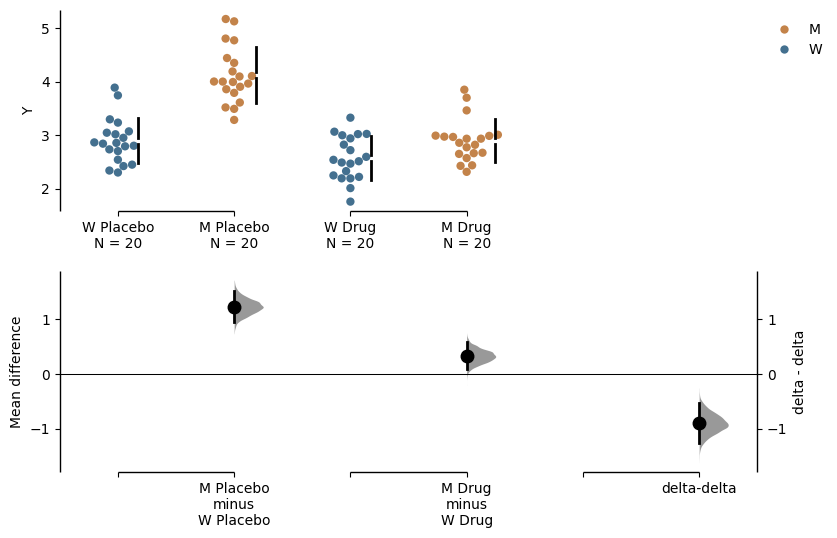

In [16]:
np.random.seed(9999) # Fix the seed so the results are replicable.
N = 20
# Create samples
y = norm.rvs(loc=3, scale=0.4, size=N*4)
y[N:2*N] = y[N:2*N]+1
y[2*N:3*N] = y[2*N:3*N]-0.5
# Add a `Treatment` column
t1 = np.repeat('Placebo', N*2).tolist()
t2 = np.repeat('Drug', N*2).tolist()
treatment = t1 + t2 
# Add a `Rep` column as the first variable for the 2 replicates of experiments done
rep = []
for i in range(N*2):
    rep.append('Rep1')
    rep.append('Rep2')
# Add a `Genotype` column as the second variable
wt = np.repeat('W', N).tolist()
mt = np.repeat('M', N).tolist()
wt2 = np.repeat('W', N).tolist()
mt2 = np.repeat('M', N).tolist()
genotype = wt + mt + wt2 + mt2
# Add an `id` column for paired data plotting.
id = list(range(0, N*2))
id_col = id + id 
# Combine all columns into a DataFrame.
df_delta2 = pd.DataFrame({'ID'        : id_col,
                  'Rep'      : rep,
                   'Genotype'  : genotype, 
                   'Treatment': treatment,
                   'Y'         : y
                })
unpaired_delta2 = dabest.load(data = df_delta2, x = ["Genotype", "Genotype"], y = "Y", delta2 = True, experiment = "Treatment")
unpaired_delta2.mean_diff.plot();

In [17]:
#| export
class MiniMetaDelta(object):
    """
    A class to compute and store the weighted delta.
    A weighted delta is calculated if the argument ``mini_meta=True`` is passed during ``dabest.load()``.
    
    """

    def __init__(self, effectsizedataframe, permutation_count,
                ci=95):

        import numpy as np
        from numpy import sort as npsort
        from numpy import sqrt, isinf, isnan
        from ._stats_tools import effsize as es
        from ._stats_tools import confint_1group as ci1g
        from ._stats_tools import confint_2group_diff as ci2g


        from string import Template
        import warnings
        
        self.__effsizedf         = effectsizedataframe.results
        self.__dabest_obj        = effectsizedataframe.dabest_obj
        self.__ci                = ci
        self.__resamples         = effectsizedataframe.resamples
        self.__alpha             = ci2g._compute_alpha_from_ci(ci)
        self.__permutation_count = permutation_count
        self.__bootstraps        = np.array(self.__effsizedf["bootstraps"])
        self.__control           = np.array(self.__effsizedf["control"])
        self.__test              = np.array(self.__effsizedf["test"])
        self.__control_N         = np.array(self.__effsizedf["control_N"])
        self.__test_N            = np.array(self.__effsizedf["test_N"])


        idx  = self.__dabest_obj.idx
        dat  = self.__dabest_obj._plot_data
        xvar = self.__dabest_obj._xvar
        yvar = self.__dabest_obj._yvar

        # compute the variances of each control group and each test group
        control_var=[]
        test_var=[]
        for j, current_tuple in enumerate(idx):
            cname = current_tuple[0]
            control = dat[dat[xvar] == cname][yvar].copy()
            control_var.append(np.var(control, ddof=1))

            tname = current_tuple[1]
            test = dat[dat[xvar] == tname][yvar].copy()
            test_var.append(np.var(test, ddof=1))
        self.__control_var = np.array(control_var)
        self.__test_var    = np.array(test_var)

        # Compute pooled group variances for each pair of experiment groups
        # based on the raw data
        self.__group_var   = ci2g.calculate_group_var(self.__control_var, 
                                                 self.__control_N,
                                                 self.__test_var, 
                                                 self.__test_N)

        # Compute the weighted average mean differences of the bootstrap data
        # using the pooled group variances of the raw data as the inverse of 
        # weights
        self.__bootstraps_weighted_delta = ci2g.calculate_weighted_delta(
                                                          self.__group_var, 
                                                          self.__bootstraps, 
                                                          self.__resamples)

        # Compute the weighted average mean difference based on the raw data
        self.__difference = es.weighted_delta(self.__effsizedf["difference"],
                                                   self.__group_var)

        sorted_weighted_deltas = npsort(self.__bootstraps_weighted_delta)


        self.__bias_correction = ci2g.compute_meandiff_bias_correction(
                                    self.__bootstraps_weighted_delta, self.__difference)
        
        self.__jackknives = np.array(ci1g.compute_1group_jackknife(
                                                self.__bootstraps_weighted_delta, 
                                                np.mean))

        self.__acceleration_value = ci2g._calc_accel(self.__jackknives)

        # Compute BCa intervals.
        bca_idx_low, bca_idx_high = ci2g.compute_interval_limits(
            self.__bias_correction, self.__acceleration_value,
            self.__resamples, ci)
        
        self.__bca_interval_idx = (bca_idx_low, bca_idx_high)

        if ~isnan(bca_idx_low) and ~isnan(bca_idx_high):
            self.__bca_low  = sorted_weighted_deltas[bca_idx_low]
            self.__bca_high = sorted_weighted_deltas[bca_idx_high]

            err1 = "The $lim_type limit of the interval"
            err2 = "was in the $loc 10 values."
            err3 = "The result should be considered unstable."
            err_temp = Template(" ".join([err1, err2, err3]))

            if bca_idx_low <= 10:
                warnings.warn(err_temp.substitute(lim_type="lower",
                                                  loc="bottom"),
                              stacklevel=1)

            if bca_idx_high >= self.__resamples-9:
                warnings.warn(err_temp.substitute(lim_type="upper",
                                                  loc="top"),
                              stacklevel=1)

        else:
            err1 = "The $lim_type limit of the BCa interval cannot be computed."
            err2 = "It is set to the effect size itself."
            err3 = "All bootstrap values were likely all the same."
            err_temp = Template(" ".join([err1, err2, err3]))

            if isnan(bca_idx_low):
                self.__bca_low  = self.__difference
                warnings.warn(err_temp.substitute(lim_type="lower"),
                              stacklevel=0)

            if isnan(bca_idx_high):
                self.__bca_high  = self.__difference
                warnings.warn(err_temp.substitute(lim_type="upper"),
                              stacklevel=0)

        # Compute percentile intervals.
        pct_idx_low  = int((self.__alpha/2)     * self.__resamples)
        pct_idx_high = int((1-(self.__alpha/2)) * self.__resamples)

        self.__pct_interval_idx = (pct_idx_low, pct_idx_high)
        self.__pct_low          = sorted_weighted_deltas[pct_idx_low]
        self.__pct_high         = sorted_weighted_deltas[pct_idx_high]

        # Generate results in a Dataframe format
        r_dict = self.to_dict()
        self.__results = pd.DataFrame.from_dict(r_dict,orient='index').reset_index()
        self.__results.columns = ['Attribute', 'Value']
        
    

    def __permutation_test(self):
        """
        Perform a permutation test and obtain the permutation p-value
        based on the permutation data.
        """
        import numpy as np
        self.__permutations     = np.array(self.__effsizedf["permutations"])
        self.__permutations_var = np.array(self.__effsizedf["permutations_var"])

        THRESHOLD = np.abs(self.__difference)

        all_num = []
        all_denom = []

        groups = len(self.__permutations)
        for i in range(0, len(self.__permutations[0])):
            weight = [1/self.__permutations_var[j][i] for j in range(0, groups)]
            all_num.append(np.sum([weight[j]*self.__permutations[j][i] for j in range(0, groups)]))
            all_denom.append(np.sum(weight))
        
        output=[]
        for i in range(0, len(all_num)):
            output.append(all_num[i]/all_denom[i])
        
        self.__permutations_weighted_delta = np.array(output)

        count = sum(np.abs(self.__permutations_weighted_delta)>THRESHOLD)
        self.__pvalue_permutation = count/self.__permutation_count



    def __repr__(self, header=True, sigfig=3):
        from .__init__ import __version__
        import datetime as dt
        import numpy as np

        from .misc_tools import print_greeting
        
        is_paired = self.__dabest_obj.is_paired

        PAIRED_STATUS = {'baseline'   : 'paired', 
                         'sequential' : 'paired',
                         'None'       : 'unpaired'
        }

        first_line = {"paired_status": PAIRED_STATUS[str(is_paired)]}
        

        out1 = "The weighted-average {paired_status} mean differences ".format(**first_line)
        
        base_string_fmt = "{:." + str(sigfig) + "}"
        if "." in str(self.__ci):
            ci_width = base_string_fmt.format(self.__ci)
        else:
            ci_width = str(self.__ci)
        
        ci_out = {"es"       : base_string_fmt.format(self.__difference),
                  "ci"       : ci_width,
                  "bca_low"  : base_string_fmt.format(self.__bca_low),
                  "bca_high" : base_string_fmt.format(self.__bca_high)}
        
        out2 = "is {es} [{ci}%CI {bca_low}, {bca_high}].".format(**ci_out)
        out = out1 + out2

        if header is True:
            out = print_greeting() + "\n" + "\n" + out


        pval_rounded = base_string_fmt.format(self.pvalue_permutation)

        
        p1 = "The p-value of the two-sided permutation t-test is {}, ".format(pval_rounded)
        p2 = "calculated for legacy purposes only. "
        pvalue = p1 + p2


        bs1 = "{} bootstrap samples were taken; ".format(self.__resamples)
        bs2 = "the confidence interval is bias-corrected and accelerated."
        bs = bs1 + bs2

        pval_def1 = "Any p-value reported is the probability of observing the" + \
                    "effect size (or greater),\nassuming the null hypothesis of" + \
                    "zero difference is true."
        pval_def2 = "\nFor each p-value, 5000 reshuffles of the " + \
                    "control and test labels were performed."
        pval_def = pval_def1 + pval_def2


        return "{}\n{}\n\n{}\n{}".format(out, pvalue, bs, pval_def)


    def to_dict(self):
        """
        Returns all attributes of the `dabest.MiniMetaDelta` object as a
        dictionary.
        """
        # Only get public (user-facing) attributes.
        attrs = [a for a in dir(self)
                 if not a.startswith(("_", "to_dict"))]
        out = {}
        for a in attrs:
            out[a] = getattr(self, a)
        return out


    @property
    def ci(self):
        """
        Returns the width of the confidence interval, in percent.
        """
        return self.__ci


    @property
    def alpha(self):
        """
        Returns the significance level of the statistical test as a float
        between 0 and 1.
        """
        return self.__alpha


    @property
    def bias_correction(self):
        return self.__bias_correction


    @property
    def bootstraps(self):
        '''
        Return the bootstrapped differences from all the experiment groups.
        '''
        return self.__bootstraps


    @property
    def jackknives(self):
        return self.__jackknives


    @property
    def acceleration_value(self):
        return self.__acceleration_value


    @property
    def bca_low(self):
        """
        The bias-corrected and accelerated confidence interval lower limit.
        """
        return self.__bca_low


    @property
    def bca_high(self):
        """
        The bias-corrected and accelerated confidence interval upper limit.
        """
        return self.__bca_high


    @property
    def bca_interval_idx(self):
        return self.__bca_interval_idx


    @property
    def control(self):
        '''
        Return the names of the control groups from all the experiment 
        groups in order.
        '''
        return self.__control


    @property
    def test(self):
        '''
        Return the names of the test groups from all the experiment 
        groups in order.
        '''
        return self.__test
    
    @property
    def control_N(self):
        '''
        Return the sizes of the control groups from all the experiment 
        groups in order.
        '''
        return self.__control_N


    @property
    def test_N(self):
        '''
        Return the sizes of the test groups from all the experiment 
        groups in order.
        '''
        return self.__test_N


    @property
    def control_var(self):
        '''
        Return the estimated population variances of the control groups 
        from all the experiment groups in order. Here the population 
        variance is estimated from the sample variance. 
        '''
        return self.__control_var


    @property
    def test_var(self):
        '''
        Return the estimated population variances of the control groups 
        from all the experiment groups in order. Here the population 
        variance is estimated from the sample variance. 
        '''
        return self.__test_var

    
    @property
    def group_var(self):
        '''
        Return the pooled group variances of all the experiment groups 
        in order. 
        '''
        return self.__group_var


    @property
    def bootstraps_weighted_delta(self):
        '''
        Return the weighted-average mean differences calculated from the bootstrapped 
        deltas and weights across the experiment groups, where the weights are 
        the inverse of the pooled group variances.
        '''
        return self.__bootstraps_weighted_delta


    @property
    def difference(self):
        '''
        Return the weighted-average delta calculated from the raw data.
        '''
        return self.__difference


    @property
    def pct_interval_idx (self):
        return self.__pct_interval_idx 


    @property
    def pct_low(self):
        """
        The percentile confidence interval lower limit.
        """
        return self.__pct_low


    @property
    def pct_high(self):
        """
        The percentile confidence interval lower limit.
        """
        return self.__pct_high


    @property
    def pvalue_permutation(self):
        try:
            return self.__pvalue_permutation
        except AttributeError:
            self.__permutation_test()
            return self.__pvalue_permutation
    

    @property
    def permutation_count(self):
        """
        The number of permuations taken.
        """
        return self.__permutation_count

    
    @property
    def permutations(self):
        '''
        Return the mean differences of permutations obtained during
        the permutation test for each experiment group.
        '''
        try:
            return self.__permutations
        except AttributeError:
            self.__permutation_test()
            return self.__permutations


    @property
    def permutations_var(self):
        '''
        Return the pooled group variances of permutations obtained during
        the permutation test for each experiment group.
        '''
        try:
            return self.__permutations_var
        except AttributeError:
            self.__permutation_test()
            return self.__permutations_var

    
    @property
    def permutations_weighted_delta(self):
        '''
        Return the weighted-average deltas of permutations obtained 
        during the permutation test.
        '''
        try:
            return self.__permutations_weighted_delta
        except AttributeError:
            self.__permutation_test()
            return self.__permutations_weighted_delta

    @property
    def results(self):
        """
        Returns the attributes of the MiniMetaDelta object as a
        Dataframe.
        """
        return self.__results



The weighted delta is calcuated as follows:

$$\theta_{\text{weighted}} = \frac{\Sigma\hat{\theta_{i}}w_{i}}{{\Sigma}w_{i}}$$

where:

$$\hat{\theta_{i}} = \text{Mean difference for replicate }i$$


$$w_{i} = \text{Weight for replicate }i = \frac{1}{s_{i}^2} $$

$$s_{i}^2 = \text{Pooled variance for replicate }i = \frac{(n_{test}-1)s_{test}^2+(n_{control}-1)s_{control}^2}{n_{test}+n_{control}-2}$$

$$n = \text{sample size and }s^2 = \text{variance for control/test.}$$


#### Example: mini-meta-delta

In [18]:
Ns = 20
c1 = norm.rvs(loc=3, scale=0.4, size=Ns)
c2 = norm.rvs(loc=3.5, scale=0.75, size=Ns)
c3 = norm.rvs(loc=3.25, scale=0.4, size=Ns)
t1 = norm.rvs(loc=3.5, scale=0.5, size=Ns)
t2 = norm.rvs(loc=2.5, scale=0.6, size=Ns)
t3 = norm.rvs(loc=3, scale=0.75, size=Ns)
my_df   = pd.DataFrame({'Control 1' : c1,     'Test 1' : t1,
                   'Control 2' : c2,     'Test 2' : t2,
                   'Control 3' : c3,     'Test 3' : t3})
my_dabest_object = dabest.load(my_df, idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")), mini_meta=True)
my_dabest_object.mean_diff.mini_meta_delta

DABEST v2023.02.14
                  
Good morning!
The current time is Sat Nov 11 02:45:12 2023.

The weighted-average unpaired mean differences is 0.0336 [95%CI -0.137, 0.228].
The p-value of the two-sided permutation t-test is 0.736, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis ofzero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

As of version 2023.02.14, weighted delta can only be calculated for mean difference, and not for standardized measures such as Cohen's *d*.

Details about the calculated weighted delta are accessed as attributes of the ``mini_meta_delta`` class. See the `minimetadelta` for details on usage.

Refer to Chapter 10 of the Cochrane handbook for further information on meta-analysis: 
https://training.cochrane.org/handbook/current/chapter-10
		

In [19]:
#| export
class TwoGroupsEffectSize(object):

    """
    A class to compute and store the results of bootstrapped
    mean differences between two groups.
    
    Compute the effect size between two groups.

        Parameters
        ----------
        control : array-like
        test : array-like
            These should be numerical iterables.
        effect_size : string.
            Any one of the following are accepted inputs:
            'mean_diff', 'median_diff', 'cohens_d', 'hedges_g', or 'cliffs_delta'
        is_paired : string, default None
        resamples : int, default 5000
            The number of bootstrap resamples to be taken for the calculation
            of the confidence interval limits.
        permutation_count : int, default 5000
            The number of permutations (reshuffles) to perform for the 
            computation of the permutation p-value
        ci : float, default 95
            The confidence interval width. The default of 95 produces 95%
            confidence intervals.
        random_seed : int, default 12345
            `random_seed` is used to seed the random number generator during
            bootstrap resampling. This ensures that the confidence intervals
            reported are replicable.

        Returns
        -------
        A :py:class:`TwoGroupEffectSize` object:
            `difference` : float
                The effect size of the difference between the control and the test.
            `effect_size` : string
                The type of effect size reported.
            `is_paired` : string
                The type of repeated-measures experiment.
            `ci` : float
                Returns the width of the confidence interval, in percent.
            `alpha` : float
                Returns the significance level of the statistical test as a float between 0 and 1.
            `resamples` : int
                The number of resamples performed during the bootstrap procedure.
            `bootstraps` : numpy ndarray
                The generated bootstraps of the effect size.
            `random_seed` : int
                The number used to initialise the numpy random seed generator, ie.`seed_value` from `numpy.random.seed(seed_value)` is returned.
            `bca_low, bca_high` : float
                The bias-corrected and accelerated confidence interval lower limit and upper limits, respectively.
            `pct_low, pct_high` : float
                The percentile confidence interval lower limit and upper limits, respectively.
    """

    def __init__(self, control, test, effect_size,
                 proportional=False,
                 is_paired=None, ci=95,
                 resamples=5000, 
                 permutation_count=5000, 
                 random_seed=12345):

        
        import numpy as np
        from numpy import array, isnan, isinf
        from numpy import sort as npsort
        from numpy.random import choice, seed

        import scipy.stats as spstats

        # import statsmodels.stats.power as power
        import statsmodels

        from string import Template
        import warnings
        
        from ._stats_tools import effsize as es
        from ._stats_tools import confint_2group_diff as ci2g


        self.__EFFECT_SIZE_DICT =  {"mean_diff" : "mean difference",
                                    "median_diff" : "median difference",
                                    "cohens_d" : "Cohen's d",
                                    "cohens_h" : "Cohen's h",
                                    "hedges_g" : "Hedges' g",
                                    "cliffs_delta" : "Cliff's delta"}


        kosher_es = [a for a in self.__EFFECT_SIZE_DICT.keys()]
        if effect_size not in kosher_es:
            err1 = "The effect size '{}'".format(effect_size)
            err2 = "is not one of {}".format(kosher_es)
            raise ValueError(" ".join([err1, err2]))

        if effect_size == "cliffs_delta" and is_paired:
            err1 = "`paired` is not None; therefore Cliff's delta is not defined."
            raise ValueError(err1)

        if proportional==True and effect_size not in ['mean_diff','cohens_h']:
            err1 = "`proportional` is True; therefore effect size other than mean_diff and cohens_h is not defined."
            raise ValueError(err1)

        if proportional==True and (np.isin(control, [0, 1]).all() == False or np.isin(test, [0, 1]).all() == False):
            err1 = "`proportional` is True; Only accept binary data consisting of 0 and 1."
            raise ValueError(err1)

        # Convert to numpy arrays for speed.
        # NaNs are automatically dropped.
        control = array(control)
        test    = array(test)
        control = control[~isnan(control)]
        test    = test[~isnan(test)]

        self.__effect_size       = effect_size
        self.__control           = control
        self.__test              = test
        self.__is_paired         = is_paired
        self.__resamples         = resamples
        self.__permutation_count = permutation_count
        self.__random_seed       = random_seed
        self.__ci                = ci
        self.__alpha             = ci2g._compute_alpha_from_ci(ci)

        self.__difference = es.two_group_difference(
                                control, test, is_paired, effect_size)
        
        self.__jackknives = ci2g.compute_meandiff_jackknife(
                                control, test, is_paired, effect_size)

        self.__acceleration_value = ci2g._calc_accel(self.__jackknives)

        bootstraps = ci2g.compute_bootstrapped_diff(
                            control, test, is_paired, effect_size,
                            resamples, random_seed)
        self.__bootstraps = bootstraps
        
        sorted_bootstraps = npsort(self.__bootstraps)
        # Added in v0.2.6.
        # Raises a UserWarning if there are any infiinities in the bootstraps.
        num_infinities = len(self.__bootstraps[isinf(self.__bootstraps)])
        
        if num_infinities > 0:
            warn_msg = "There are {} bootstrap(s) that are not defined. "\
            "This is likely due to smaple sample sizes. "\
            "The values in a bootstrap for a group will be more likely "\
            "to be all equal, with a resulting variance of zero. "\
            "The computation of Cohen's d and Hedges' g thus "\
            "involved a division by zero. "
            warnings.warn(warn_msg.format(num_infinities), 
                          category=UserWarning)

        self.__bias_correction = ci2g.compute_meandiff_bias_correction(
                                    self.__bootstraps, self.__difference)

        # Compute BCa intervals.
        bca_idx_low, bca_idx_high = ci2g.compute_interval_limits(
            self.__bias_correction, self.__acceleration_value,
            self.__resamples, ci)

        self.__bca_interval_idx = (bca_idx_low, bca_idx_high)

        if ~isnan(bca_idx_low) and ~isnan(bca_idx_high):
            self.__bca_low  = sorted_bootstraps[bca_idx_low]
            self.__bca_high = sorted_bootstraps[bca_idx_high]

            err1 = "The $lim_type limit of the interval"
            err2 = "was in the $loc 10 values."
            err3 = "The result should be considered unstable."
            err_temp = Template(" ".join([err1, err2, err3]))

            if bca_idx_low <= 10:
                warnings.warn(err_temp.substitute(lim_type="lower",
                                                  loc="bottom"),
                              stacklevel=1)

            if bca_idx_high >= resamples-9:
                warnings.warn(err_temp.substitute(lim_type="upper",
                                                  loc="top"),
                              stacklevel=1)

        else:
            err1 = "The $lim_type limit of the BCa interval cannot be computed."
            err2 = "It is set to the effect size itself."
            err3 = "All bootstrap values were likely all the same."
            err_temp = Template(" ".join([err1, err2, err3]))

            if isnan(bca_idx_low):
                self.__bca_low  = self.__difference
                warnings.warn(err_temp.substitute(lim_type="lower"),
                              stacklevel=0)

            if isnan(bca_idx_high):
                self.__bca_high  = self.__difference
                warnings.warn(err_temp.substitute(lim_type="upper"),
                              stacklevel=0)

        # Compute percentile intervals.
        pct_idx_low  = int((self.__alpha/2)     * resamples)
        pct_idx_high = int((1-(self.__alpha/2)) * resamples)

        self.__pct_interval_idx = (pct_idx_low, pct_idx_high)
        self.__pct_low  = sorted_bootstraps[pct_idx_low]
        self.__pct_high = sorted_bootstraps[pct_idx_high]

        # Perform statistical tests.
                
        self.__PermutationTest_result = PermutationTest(control, test, 
                                                        effect_size, 
                                                        is_paired,
                                                        permutation_count)
        
        if is_paired and proportional is False:
            # Wilcoxon, a non-parametric version of the paired T-test.
            wilcoxon = spstats.wilcoxon(control, test)
            self.__pvalue_wilcoxon = wilcoxon.pvalue
            self.__statistic_wilcoxon = wilcoxon.statistic
            
            
            if effect_size != "median_diff":
                # Paired Student's t-test.
                paired_t = spstats.ttest_rel(control, test, nan_policy='omit')
                self.__pvalue_paired_students_t = paired_t.pvalue
                self.__statistic_paired_students_t = paired_t.statistic

                standardized_es = es.cohens_d(control, test, is_paired)
                # self.__power = power.tt_solve_power(standardized_es,
                #                                     len(control),
                #                                     alpha=self.__alpha)

        elif is_paired and proportional is True:
            # for binary paired data, use McNemar's test
            # References:
            # https://en.wikipedia.org/wiki/McNemar%27s_test
            from statsmodels.stats.contingency_tables import mcnemar
            import pandas as pd
            df_temp = pd.DataFrame({'control': control, 'test': test})
            x1 = len(df_temp[(df_temp['control'] == 0)&(df_temp['test'] == 0)])
            x2 = len(df_temp[(df_temp['control'] == 0)&(df_temp['test'] == 1)])
            x3 = len(df_temp[(df_temp['control'] == 1)&(df_temp['test'] == 0)])
            x4 = len(df_temp[(df_temp['control'] == 1)&(df_temp['test'] == 1)])
            table =  [[x1,x2],[x3,x4]]
            _mcnemar = mcnemar(table, exact=True, correction=True)
            self.__pvalue_mcnemar = _mcnemar.pvalue
            self.__statistic_mcnemar = _mcnemar.statistic

        elif effect_size == "cliffs_delta":
            # Let's go with Brunner-Munzel!
            brunner_munzel = spstats.brunnermunzel(control, test,
                                                     nan_policy='omit')
            self.__pvalue_brunner_munzel = brunner_munzel.pvalue
            self.__statistic_brunner_munzel = brunner_munzel.statistic


        elif effect_size == "median_diff":
            # According to scipy's documentation of the function,
            # "The Kruskal-Wallis H-test tests the null hypothesis
            # that the population median of all of the groups are equal."
            kruskal = spstats.kruskal(control, test, nan_policy='omit')
            self.__pvalue_kruskal = kruskal.pvalue
            self.__statistic_kruskal = kruskal.statistic
            # self.__power = np.nan

        else: # for mean difference, Cohen's d, and Hedges' g.
            # Welch's t-test, assumes normality of distributions,
            # but does not assume equal variances.
            welch = spstats.ttest_ind(control, test, equal_var=False,
                                       nan_policy='omit')
            self.__pvalue_welch = welch.pvalue
            self.__statistic_welch = welch.statistic

            # Student's t-test, assumes normality of distributions,
            # as well as assumption of equal variances.
            students_t = spstats.ttest_ind(control, test, equal_var=True,
                                            nan_policy='omit')
            self.__pvalue_students_t = students_t.pvalue
            self.__statistic_students_t = students_t.statistic

            # Mann-Whitney test: Non parametric,
            # does not assume normality of distributions
            try:
                mann_whitney = spstats.mannwhitneyu(control, test, 
                                                    alternative='two-sided')
                self.__pvalue_mann_whitney = mann_whitney.pvalue
                self.__statistic_mann_whitney = mann_whitney.statistic
            except ValueError:
                # Occurs when the control and test are exactly identical
                # in terms of rank (eg. all zeros.)
                pass
            
                    

            standardized_es = es.cohens_d(control, test, is_paired = None)
            
            # The Cohen's h calculation is for binary categorical data
            try:
                self.__proportional_difference = es.cohens_h(control, test)
            except ValueError:
                # Occur only when the data consists not only 0's and 1's.
                pass
            # self.__power = power.tt_ind_solve_power(standardized_es,
            #                                         len(control),
            #                                         alpha=self.__alpha,
            #                                         ratio=len(test)/len(control)
            #                                         )






    def __repr__(self, show_resample_count=True, define_pval=True, sigfig=3):
        
        # # Deprecated in v0.3.0; permutation p-values will be reported by default.
        # UNPAIRED_ES_TO_TEST = {"mean_diff"    : "Mann-Whitney",
        #                        "median_diff"  : "Kruskal",
        #                        "cohens_d"     : "Mann-Whitney",
        #                        "hedges_g"     : "Mann-Whitney",
        #                        "cliffs_delta" : "Brunner-Munzel"}
        # 
        # TEST_TO_PVAL_ATTR = {"Mann-Whitney"    : "pvalue_mann_whitney",
        #                      "Kruskal"        :  "pvalue_kruskal",
        #                      "Brunner-Munzel" :  "pvalue_brunner_munzel",
        #                      "Wilcoxon"       :  "pvalue_wilcoxon"}
        
        RM_STATUS = {'baseline'  : 'for repeated measures against baseline \n', 
                     'sequential': 'for the sequential design of repeated-measures experiment \n',
                     'None'      : ''
                    }

        PAIRED_STATUS = {'baseline'   : 'paired', 
                         'sequential' : 'paired',
                         'None'       : 'unpaired'
        }

        first_line = {"rm_status"    : RM_STATUS[str(self.__is_paired)],
                      "es"           : self.__EFFECT_SIZE_DICT[self.__effect_size],
                      "paired_status": PAIRED_STATUS[str(self.__is_paired)]}
        

        out1 = "The {paired_status} {es} {rm_status}".format(**first_line)
        
        base_string_fmt = "{:." + str(sigfig) + "}"
        if "." in str(self.__ci):
            ci_width = base_string_fmt.format(self.__ci)
        else:
            ci_width = str(self.__ci)
        
        ci_out = {"es"       : base_string_fmt.format(self.__difference),
                  "ci"       : ci_width,
                  "bca_low"  : base_string_fmt.format(self.__bca_low),
                  "bca_high" : base_string_fmt.format(self.__bca_high)}
        
        out2 = "is {es} [{ci}%CI {bca_low}, {bca_high}].".format(**ci_out)
        out = out1 + out2
        
        # # Deprecated in v0.3.0; permutation p-values will be reported by default.
        # if self.__is_paired:
        #     stats_test = "Wilcoxon"
        # else:
        #     stats_test = UNPAIRED_ES_TO_TEST[self.__effect_size]
        
        
        # pval_rounded = base_string_fmt.format(getattr(self,
        #                                              TEST_TO_PVAL_ATTR[stats_test])
        #                                       )
        
        pval_rounded = base_string_fmt.format(self.pvalue_permutation)
        
        # # Deprecated in v0.3.0; permutation p-values will be reported by default.
        # pvalue = "The two-sided p-value of the {} test is {}.".format(stats_test,
        #                                                         pval_rounded)
        
        # pvalue = "The two-sided p-value of the {} test is {}.".format(stats_test,
        #                                                         pval_rounded)
        
        
        p1 = "The p-value of the two-sided permutation t-test is {}, ".format(pval_rounded)
        p2 = "calculated for legacy purposes only. "
        pvalue = p1 + p2
                                                                
        bs1 = "{} bootstrap samples were taken; ".format(self.__resamples)
        bs2 = "the confidence interval is bias-corrected and accelerated."
        bs = bs1 + bs2

        pval_def1 = "Any p-value reported is the probability of observing the" + \
                    "effect size (or greater),\nassuming the null hypothesis of" + \
                    "zero difference is true."
        pval_def2 = "\nFor each p-value, 5000 reshuffles of the " + \
                    "control and test labels were performed."
        pval_def = pval_def1 + pval_def2

        if show_resample_count and define_pval:
            return "{}\n{}\n\n{}\n{}".format(out, pvalue, bs, pval_def)
        elif show_resample_count is False and define_pval is True:
            return "{}\n{}\n\n{}".format(out, pvalue, pval_def)
        elif show_resample_count is True and define_pval is False:
            return "{}\n{}\n\n{}".format(out, pvalue, bs)
        else:
            return "{}\n{}".format(out, pvalue)



    def to_dict(self):
        """
        Returns the attributes of the `dabest.TwoGroupEffectSize` object as a
        dictionary.
        """
        # Only get public (user-facing) attributes.
        attrs = [a for a in dir(self)
                 if not a.startswith(("_", "to_dict"))]
        out = {}
        for a in attrs:
            out[a] = getattr(self, a)
        return out


    @property
    def difference(self):
        """
        Returns the difference between the control and the test.
        """
        return self.__difference

    @property
    def effect_size(self):
        """
        Returns the type of effect size reported.
        """
        return self.__EFFECT_SIZE_DICT[self.__effect_size]

    @property
    def is_paired(self):
        return self.__is_paired

    @property
    def ci(self):
        """
        Returns the width of the confidence interval, in percent.
        """
        return self.__ci

    @property
    def alpha(self):
        """
        Returns the significance level of the statistical test as a float
        between 0 and 1.
        """
        return self.__alpha

    @property
    def resamples(self):
        """
        The number of resamples performed during the bootstrap procedure.
        """
        return self.__resamples

    @property
    def bootstraps(self):
        """
        The generated bootstraps of the effect size.
        """
        return self.__bootstraps

    @property
    def random_seed(self):
        """
        The number used to initialise the numpy random seed generator, ie.
        `seed_value` from `numpy.random.seed(seed_value)` is returned.
        """
        return self.__random_seed

    @property
    def bca_interval_idx(self):
        return self.__bca_interval_idx

    @property
    def bca_low(self):
        """
        The bias-corrected and accelerated confidence interval lower limit.
        """
        return self.__bca_low

    @property
    def bca_high(self):
        """
        The bias-corrected and accelerated confidence interval upper limit.
        """
        return self.__bca_high

    @property
    def pct_interval_idx(self):
        return self.__pct_interval_idx

    @property
    def pct_low(self):
        """
        The percentile confidence interval lower limit.
        """
        return self.__pct_low

    @property
    def pct_high(self):
        """
        The percentile confidence interval lower limit.
        """
        return self.__pct_high



    @property
    def pvalue_brunner_munzel(self):
        from numpy import nan as npnan
        try:
            return self.__pvalue_brunner_munzel
        except AttributeError:
            return npnan

    @property
    def statistic_brunner_munzel(self):
        from numpy import nan as npnan
        try:
            return self.__statistic_brunner_munzel
        except AttributeError:
            return npnan



    @property
    def pvalue_wilcoxon(self):
        from numpy import nan as npnan
        try:
            return self.__pvalue_wilcoxon
        except AttributeError:
            return npnan

    @property
    def statistic_wilcoxon(self):
        from numpy import nan as npnan
        try:
            return self.__statistic_wilcoxon
        except AttributeError:
            return npnan

    @property
    def pvalue_mcnemar(self):
        from numpy import nan as npnan
        try:
            return self.__pvalue_mcnemar
        except AttributeError:
            return npnan

    @property
    def statistic_mcnemar(self):
        from numpy import nan as npnan
        try:
            return self.__statistic_mcnemar
        except AttributeError:
            return npnan



    @property
    def pvalue_paired_students_t(self):
        from numpy import nan as npnan
        try:
            return self.__pvalue_paired_students_t
        except AttributeError:
            return npnan

    @property
    def statistic_paired_students_t(self):
        from numpy import nan as npnan
        try:
            return self.__statistic_paired_students_t
        except AttributeError:
            return npnan



    @property
    def pvalue_kruskal(self):
        from numpy import nan as npnan
        try:
            return self.__pvalue_kruskal
        except AttributeError:
            return npnan

    @property
    def statistic_kruskal(self):
        from numpy import nan as npnan
        try:
            return self.__statistic_kruskal
        except AttributeError:
            return npnan



    @property
    def pvalue_welch(self):
        from numpy import nan as npnan
        try:
            return self.__pvalue_welch
        except AttributeError:
            return npnan

    @property
    def statistic_welch(self):
        from numpy import nan as npnan
        try:
            return self.__statistic_welch
        except AttributeError:
            return npnan



    @property
    def pvalue_students_t(self):
        from numpy import nan as npnan
        try:
            return self.__pvalue_students_t
        except AttributeError:
            return npnan

    @property
    def statistic_students_t(self):
        from numpy import nan as npnan
        try:
            return self.__statistic_students_t
        except AttributeError:
            return npnan



    @property
    def pvalue_mann_whitney(self):
        from numpy import nan as npnan
        try:
            return self.__pvalue_mann_whitney
        except AttributeError:
            return npnan



    @property
    def statistic_mann_whitney(self):
        from numpy import nan as npnan
        try:
            return self.__statistic_mann_whitney
        except AttributeError:
            return npnan
            
    # Introduced in v0.3.0.
    @property
    def pvalue_permutation(self):
        return self.__PermutationTest_result.pvalue
    
    # 
    # 
    @property
    def permutation_count(self):
        """
        The number of permuations taken.
        """
        return self.__PermutationTest_result.permutation_count

    
    @property
    def permutations(self):
        return self.__PermutationTest_result.permutations

    
    @property
    def permutations_var(self):
        return self.__PermutationTest_result.permutations_var


    @property
    def proportional_difference(self):
        from numpy import nan as npnan
        try:
            return self.__proportional_difference
        except AttributeError:
            return npnan


#### Example

In [20]:
np.random.seed(12345)
control = norm.rvs(loc=0, size=30)
test = norm.rvs(loc=0.5, size=30)
effsize = dabest.TwoGroupsEffectSize(control, test, "mean_diff")
effsize

The unpaired mean difference is -0.253 [95%CI -0.78, 0.25].
The p-value of the two-sided permutation t-test is 0.348, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis ofzero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

In [21]:
effsize.to_dict() 

{'alpha': 0.05,
 'bca_high': 0.24951887238295106,
 'bca_interval_idx': (125, 4875),
 'bca_low': -0.7801782111071534,
 'bootstraps': array([-0.3649424 , -0.45018155, -0.56034412, ..., -0.49805581,
        -0.25334475, -0.55206229]),
 'ci': 95,
 'difference': -0.25315417702752846,
 'effect_size': 'mean difference',
 'is_paired': None,
 'pct_high': 0.24951887238295106,
 'pct_interval_idx': (125, 4875),
 'pct_low': -0.7801782111071534,
 'permutation_count': 5000,
 'permutations': array([ 0.17221029,  0.03112419, -0.13911387, ..., -0.38007941,
         0.30261507, -0.09073054]),
 'permutations_var': array([0.07201642, 0.07251104, 0.07219407, ..., 0.07003705, 0.07094885,
        0.07238581]),
 'proportional_difference': nan,
 'pvalue_brunner_munzel': nan,
 'pvalue_kruskal': nan,
 'pvalue_mann_whitney': 0.5201446121616038,
 'pvalue_mcnemar': nan,
 'pvalue_paired_students_t': nan,
 'pvalue_permutation': 0.3484,
 'pvalue_students_t': 0.34743913903372836,
 'pvalue_welch': 0.3474493875548964,
 'p

In [22]:
#| export
class EffectSizeDataFrame(object):
    """A class that generates and stores the results of bootstrapped effect
    sizes for several comparisons."""

    def __init__(self, dabest, effect_size,
                 is_paired, ci=95, proportional=False,
                 resamples=5000, 
                 permutation_count=5000,
                 random_seed=12345, 
                 x1_level=None, x2=None, 
                 delta2=False, experiment_label=None,
                 mini_meta=False):
        """
        Parses the data from a Dabest object, enabling plotting and printing
        capability for the effect size of interest.
        """

        self.__dabest_obj        = dabest
        self.__effect_size       = effect_size
        self.__is_paired         = is_paired
        self.__ci                = ci
        self.__resamples         = resamples
        self.__permutation_count = permutation_count
        self.__random_seed       = random_seed
        self.__proportional      = proportional
        self.__x1_level          = x1_level
        self.__experiment_label  = experiment_label 
        self.__x2                = x2
        self.__delta2            = delta2 
        self.__mini_meta         = mini_meta


    def __pre_calc(self):
        import pandas as pd
        from .misc_tools import print_greeting, get_varname

        idx  = self.__dabest_obj.idx
        dat  = self.__dabest_obj._plot_data
        xvar = self.__dabest_obj._xvar
        yvar = self.__dabest_obj._yvar

        out = []
        reprs = []

        for j, current_tuple in enumerate(idx):
            if self.__is_paired!="sequential":
                cname = current_tuple[0]
                control = dat[dat[xvar] == cname][yvar].copy()

            for ix, tname in enumerate(current_tuple[1:]):
                if self.__is_paired == "sequential":
                    cname = current_tuple[ix]
                    control = dat[dat[xvar] == cname][yvar].copy()
                test = dat[dat[xvar] == tname][yvar].copy()

                result = TwoGroupsEffectSize(control, test,
                                             self.__effect_size,
                                             self.__proportional,
                                             self.__is_paired,
                                             self.__ci,
                                             self.__resamples,
                                             self.__permutation_count,
                                             self.__random_seed)
                r_dict = result.to_dict()
                r_dict["control"]   = cname
                r_dict["test"]      = tname
                r_dict["control_N"] = int(len(control))
                r_dict["test_N"]    = int(len(test))
                out.append(r_dict)
                if j == len(idx)-1 and ix == len(current_tuple)-2:
                    if self.__delta2 and self.__effect_size == "mean_diff":
                        resamp_count = False
                        def_pval     = False
                    elif self.__mini_meta and self.__effect_size == "mean_diff":
                        resamp_count = False
                        def_pval     = False
                    else:
                        resamp_count = True
                        def_pval     = True
                else:
                    resamp_count = False
                    def_pval     = False

                text_repr = result.__repr__(show_resample_count=resamp_count,
                                            define_pval=def_pval)

                to_replace = "between {} and {} is".format(cname, tname)
                text_repr = text_repr.replace("is", to_replace, 1)

                reprs.append(text_repr)


        self.__for_print = "\n\n".join(reprs)

        out_             = pd.DataFrame(out)

        columns_in_order = ['control', 'test', 'control_N', 'test_N',
                            'effect_size', 'is_paired',
                            'difference', 'ci',

                            'bca_low', 'bca_high', 'bca_interval_idx',
                            'pct_low', 'pct_high', 'pct_interval_idx',
                            
                            'bootstraps', 'resamples', 'random_seed',
                            
                            'permutations', 'pvalue_permutation', 'permutation_count', 'permutations_var',
                            
                            'pvalue_welch',
                            'statistic_welch',

                            'pvalue_students_t',
                            'statistic_students_t',

                            'pvalue_mann_whitney',
                            'statistic_mann_whitney',

                            'pvalue_brunner_munzel',
                            'statistic_brunner_munzel',

                            'pvalue_wilcoxon',
                            'statistic_wilcoxon',

                            'pvalue_mcnemar',
                            'statistic_mcnemar',

                            'pvalue_paired_students_t',
                            'statistic_paired_students_t',

                            'pvalue_kruskal',
                            'statistic_kruskal',
                            'proportional_difference'
                           ]
        self.__results   = out_.reindex(columns=columns_in_order)
        self.__results.dropna(axis="columns", how="all", inplace=True)
        
        # Add the is_paired column back when is_paired is None
        if self.is_paired is None:
            self.__results.insert(5, 'is_paired', self.__results.apply(lambda _: None, axis=1))
        
        # Create and compute the delta-delta statistics
        if self.__delta2 is True and self.__effect_size == "mean_diff":
            self.__delta_delta = DeltaDelta(self,
                                            self.__permutation_count,
                                            self.__ci)
            reprs.append(self.__delta_delta.__repr__(header=False))
        elif self.__delta2 is True and self.__effect_size != "mean_diff":
            self.__delta_delta = "Delta-delta is not supported for {}.".format(self.__effect_size)
        else:
            self.__delta_delta = "`delta2` is False; delta-delta is therefore not calculated."

        # Create and compute the weighted average statistics
        if self.__mini_meta is True and self.__effect_size == "mean_diff":
            self.__mini_meta_delta = MiniMetaDelta(self,
                                                     self.__permutation_count,
                                                     self.__ci)
            reprs.append(self.__mini_meta_delta.__repr__(header=False))
        elif self.__mini_meta is True and self.__effect_size != "mean_diff":
            self.__mini_meta_delta = "Weighted delta is not supported for {}.".format(self.__effect_size)
        else:
            self.__mini_meta_delta = "`mini_meta` is False; weighted delta is therefore not calculated."
        
        
        varname = get_varname(self.__dabest_obj)
        lastline = "To get the results of all valid statistical tests, " +\
        "use `{}.{}.statistical_tests`".format(varname, self.__effect_size)
        reprs.append(lastline)

        reprs.insert(0, print_greeting())

        self.__for_print = "\n\n".join(reprs)


    def __repr__(self):
        try:
            return self.__for_print
        except AttributeError:
            self.__pre_calc()
            return self.__for_print
            
            
            
    def __calc_lqrt(self):
        import lqrt
        import pandas as pd
        
        rnd_seed = self.__random_seed
        db_obj = self.__dabest_obj
        dat  = db_obj._plot_data
        xvar = db_obj._xvar
        yvar = db_obj._yvar
        delta2 = self.__delta2
        

        out = []

        for j, current_tuple in enumerate(db_obj.idx):
            if self.__is_paired != "sequential":
                cname = current_tuple[0]
                control = dat[dat[xvar] == cname][yvar].copy()

            for ix, tname in enumerate(current_tuple[1:]):
                if self.__is_paired == "sequential":
                    cname = current_tuple[ix]
                    control = dat[dat[xvar] == cname][yvar].copy()
                test = dat[dat[xvar] == tname][yvar].copy()
                
                if self.__is_paired:                    
                    # Refactored here in v0.3.0 for performance issues.
                    lqrt_result = lqrt.lqrtest_rel(control, test, 
                                            random_state=rnd_seed)
                    
                    out.append({"control": cname, "test": tname, 
                                "control_N": int(len(control)), 
                                "test_N": int(len(test)),
                                "pvalue_paired_lqrt": lqrt_result.pvalue,
                                "statistic_paired_lqrt": lqrt_result.statistic
                                })

                else:
                    # Likelihood Q-Ratio test:
                    lqrt_equal_var_result = lqrt.lqrtest_ind(control, test, 
                                                random_state=rnd_seed,
                                                equal_var=True)
                                                
                                                
                    lqrt_unequal_var_result = lqrt.lqrtest_ind(control, test, 
                                                random_state=rnd_seed,
                                                equal_var=False)
                                                
                    out.append({"control": cname, "test": tname, 
                                "control_N": int(len(control)), 
                                "test_N": int(len(test)),
                                
                                "pvalue_lqrt_equal_var"      : lqrt_equal_var_result.pvalue,
                                "statistic_lqrt_equal_var"   : lqrt_equal_var_result.statistic,
                                "pvalue_lqrt_unequal_var"    : lqrt_unequal_var_result.pvalue,
                                "statistic_lqrt_unequal_var" : lqrt_unequal_var_result.statistic,
                                })                     
        self.__lqrt_results = pd.DataFrame(out)


    def plot(self, color_col=None,

            raw_marker_size=6, es_marker_size=9,

            swarm_label=None, barchart_label=None, contrast_label=None, delta2_label=None,
            swarm_ylim=None, barchart_ylim=None, contrast_ylim=None, delta2_ylim=None,

            custom_palette=None, swarm_desat=0.5, halfviolin_desat=1,
            halfviolin_alpha=0.8, 

            face_color = None,
            #bar plot
            bar_label=None, bar_desat=0.5, bar_width = 0.5,bar_ylim = None,
            # error bar of proportion plot
            ci=None, ci_type='bca', err_color=None,

            float_contrast=True,
            show_pairs=True,
            show_delta2=True,
            show_mini_meta=True,
            group_summaries=None,
            group_summaries_offset=0.1,

            fig_size=None,
            dpi=100,
            ax=None,

            swarmplot_kwargs=None,
            barplot_kwargs=None,
            violinplot_kwargs=None,
            slopegraph_kwargs=None,
            sankey_kwargs=None,
            reflines_kwargs=None,
            group_summary_kwargs=None,
            legend_kwargs=None):

        """
        Creates an estimation plot for the effect size of interest.
        

        Parameters
        ----------
        color_col : string, default None
            Column to be used for colors.
        raw_marker_size : float, default 6
            The diameter (in points) of the marker dots plotted in the
            swarmplot.
        es_marker_size : float, default 9
            The size (in points) of the effect size points on the difference
            axes.
        swarm_label, contrast_label, delta2_label : strings, default None
            Set labels for the y-axis of the swarmplot and the contrast plot,
            respectively. If `swarm_label` is not specified, it defaults to
            "value", unless a column name was passed to `y`. If
            `contrast_label` is not specified, it defaults to the effect size
            being plotted. If `delta2_label` is not specifed, it defaults to 
            "delta - delta"
        swarm_ylim, contrast_ylim, delta2_ylim : tuples, default None
            The desired y-limits of the raw data (swarmplot) axes, the
            difference axes and the delta-delta axes respectively, as a tuple. 
            These will be autoscaled to sensible values if they are not 
            specified. The delta2 axes and contrast axes should have the same 
            limits for y. When `show_delta2` is True, if both of the `contrast_ylim`
            and `delta2_ylim` are not None, then they must be specified with the 
            same values; when `show_delta2` is True and only one of them is specified,
            then the other will automatically be assigned with the same value.
            Specifying `delta2_ylim` does not have any effect when `show_delta2` is
            False. 
        custom_palette : dict, list, or matplotlib color palette, default None
            This keyword accepts a dictionary with {'group':'color'} pairings,
            a list of RGB colors, or a specified matplotlib palette. This
            palette will be used to color the swarmplot. If `color_col` is not
            specified, then each group will be colored in sequence according
            to the default palette currently used by matplotlib.
            Please take a look at the seaborn commands `color_palette`
            and `cubehelix_palette` to generate a custom palette. Both
            these functions generate a list of RGB colors.
            See:
            https://seaborn.pydata.org/generated/seaborn.color_palette.html
            https://seaborn.pydata.org/generated/seaborn.cubehelix_palette.html
            The named colors of matplotlib can be found here:
            https://matplotlib.org/examples/color/named_colors.html
        swarm_desat : float, default 1
            Decreases the saturation of the colors in the swarmplot by the
            desired proportion. Uses `seaborn.desaturate()` to acheive this.
        halfviolin_desat : float, default 0.5
            Decreases the saturation of the colors of the half-violin bootstrap
            curves by the desired proportion. Uses `seaborn.desaturate()` to
            acheive this.
        halfviolin_alpha : float, default 0.8
            The alpha (transparency) level of the half-violin bootstrap curves.            
        float_contrast : boolean, default True
            Whether or not to display the halfviolin bootstrapped difference
            distribution alongside the raw data.
        show_pairs : boolean, default True
            If the data is paired, whether or not to show the raw data as a
            swarmplot, or as slopegraph, with a line joining each pair of
            observations.
        show_delta2, show_mini_meta : boolean, default True
            If delta-delta or mini-meta delta is calculated, whether or not to 
            show the delta-delta plot or mini-meta plot.
        group_summaries : ['mean_sd', 'median_quartiles', 'None'], default None.
            Plots the summary statistics for each group. If 'mean_sd', then
            the mean and standard deviation of each group is plotted as a
            notched line beside each group. If 'median_quantiles', then the
            median and 25th and 75th percentiles of each group is plotted
            instead. If 'None', the summaries are not shown.
        group_summaries_offset : float, default 0.1
            If group summaries are displayed, they will be offset from the raw
            data swarmplot groups by this value. 
        fig_size : tuple, default None
            The desired dimensions of the figure as a (length, width) tuple.
        dpi : int, default 100
            The dots per inch of the resulting figure.
        ax : matplotlib.Axes, default None
            Provide an existing Axes for the plots to be created. If no Axes is
            specified, a new matplotlib Figure will be created.
        swarmplot_kwargs : dict, default None
            Pass any keyword arguments accepted by the seaborn `swarmplot`
            command here, as a dict. If None, the following keywords are
            passed to sns.swarmplot : {'size':`raw_marker_size`}.
        violinplot_kwargs : dict, default None
            Pass any keyword arguments accepted by the matplotlib `
            pyplot.violinplot` command here, as a dict. If None, the following
            keywords are passed to violinplot : {'widths':0.5, 'vert':True,
            'showextrema':False, 'showmedians':False}.
        slopegraph_kwargs : dict, default None
            This will change the appearance of the lines used to join each pair
            of observations when `show_pairs=True`. Pass any keyword arguments
            accepted by matplotlib `plot()` function here, as a dict.
            If None, the following keywords are
            passed to plot() : {'linewidth':1, 'alpha':0.5}.
        sankey_kwargs: dict, default None
            Whis will change the appearance of the sankey diagram used to depict
            paired proportional data when `show_pairs=True` and `proportional=True`. 
            Pass any keyword arguments accepted by plot_tools.sankeydiag() function
            here, as a dict. If None, the following keywords are passed to sankey diagram:
            {"width": 0.5, "align": "center", "alpha": 0.4, "bar_width": 0.1, "rightColor": False}
        reflines_kwargs : dict, default None
            This will change the appearance of the zero reference lines. Pass
            any keyword arguments accepted by the matplotlib Axes `hlines`
            command here, as a dict. If None, the following keywords are
            passed to Axes.hlines : {'linestyle':'solid', 'linewidth':0.75,
            'zorder':2, 'color' : default y-tick color}.
        group_summary_kwargs : dict, default None
            Pass any keyword arguments accepted by the matplotlib.lines.Line2D
            command here, as a dict. This will change the appearance of the
            vertical summary lines for each group, if `group_summaries` is not
            'None'. If None, the following keywords are passed to
            matplotlib.lines.Line2D : {'lw':2, 'alpha':1, 'zorder':3}.
        legend_kwargs : dict, default None
            Pass any keyword arguments accepted by the matplotlib Axes
            `legend` command here, as a dict. If None, the following keywords
            are passed to matplotlib.Axes.legend : {'loc':'upper left',
            'frameon':False}.


        Returns
        -------
        A :class:`matplotlib.figure.Figure` with 2 Axes, if ``ax = None``.
        
        The first axes (accessible with ``FigName.axes[0]``) contains the rawdata swarmplot; the second axes (accessible with ``FigName.axes[1]``) has the bootstrap distributions and effect sizes (with confidence intervals) plotted on it.
        
        If ``ax`` is specified, the rawdata swarmplot is accessed at ``ax`` 
        itself, while the effect size axes is accessed at ``ax.contrast_axes``.
        See the last example below.
        


        """

        from .plotter import EffectSizeDataFramePlotter

        if hasattr(self, "results") is False:
            self.__pre_calc()

        if self.__delta2:
            color_col = self.__x2

        # if self.__proportional:
        #     raw_marker_size = 0.01
            
        all_kwargs = locals()
        del all_kwargs["self"]

        out = EffectSizeDataFramePlotter(self, **all_kwargs)

        return out


    @property
    def proportional(self):
        """
        Returns the proportional parameter
        class.
        """
        return self.__proportional

    @property
    def results(self):
        """Prints all pairwise comparisons nicely."""
        try:
            return self.__results
        except AttributeError:
            self.__pre_calc()
            return self.__results



    @property
    def statistical_tests(self):
        results_df = self.results

        # Select only the statistics and p-values.
        stats_columns = [c for c in results_df.columns
                         if c.startswith("statistic") or c.startswith("pvalue")]

        default_cols = ['control', 'test', 'control_N', 'test_N',
                        'effect_size', 'is_paired',
                        'difference', 'ci', 'bca_low', 'bca_high']

        cols_of_interest = default_cols + stats_columns

        return results_df[cols_of_interest]


    @property
    def _for_print(self):
        return self.__for_print

    @property
    def _plot_data(self):
        return self.__dabest_obj._plot_data

    @property
    def idx(self):
        return self.__dabest_obj.idx

    @property
    def xvar(self):
        return self.__dabest_obj._xvar

    @property
    def yvar(self):
        return self.__dabest_obj._yvar

    @property
    def is_paired(self):
        return self.__is_paired

    @property
    def ci(self):
        """
        The width of the confidence interval being produced, in percent.
        """
        return self.__ci

    @property
    def x1_level(self):
        return self.__x1_level


    @property
    def x2(self):
        return self.__x2


    @property
    def experiment_label(self):
        return self.__experiment_label
    

    @property
    def delta2(self):
        return self.__delta2
    

    @property
    def resamples(self):
        """
        The number of resamples (with replacement) during bootstrap resampling."
        """
        return self.__resamples

    @property
    def random_seed(self):
        """
        The seed used by `numpy.seed()` for bootstrap resampling.
        """
        return self.__random_seed

    @property
    def effect_size(self):
        """The type of effect size being computed."""
        return self.__effect_size

    @property
    def dabest_obj(self):
        """
        Returns the `dabest` object that invoked the current EffectSizeDataFrame
        class.
        """
        return self.__dabest_obj

    @property
    def proportional(self):
        """
        Returns the proportional parameter
        class.
        """
        return self.__proportional
        
    @property
    def lqrt(self):
        """Returns all pairwise Lq-Likelihood Ratio Type test results 
        as a pandas DataFrame.
        
        For more information on LqRT tests, see https://arxiv.org/abs/1911.11922
        """
        try:
            return self.__lqrt_results
        except AttributeError:
            self.__calc_lqrt()
            return self.__lqrt_results
        
    
    @property
    def mini_meta(self):
        """
        Returns the mini_meta boolean parameter.
        """
        return self.__mini_meta

    
    @property
    def mini_meta_delta(self):
        """
        Returns the mini_meta results.
        """
        try:
            return self.__mini_meta_delta
        except AttributeError:
            self.__pre_calc()
            return self.__mini_meta_delta

    
    @property
    def delta_delta(self):
        """
        Returns the mini_meta results.
        """
        try:
            return self.__delta_delta
        except AttributeError:
            self.__pre_calc()
            return self.__delta_delta



#### Example: plot

Create a Gardner-Altman estimation plot for the mean difference.

In [23]:
np.random.seed(9999) # Fix the seed so the results are replicable.
# pop_size = 10000 # Size of each population.
Ns = 20 # The number of samples taken from each population

# Create samples
c1 = norm.rvs(loc=3, scale=0.4, size=Ns)
c2 = norm.rvs(loc=3.5, scale=0.75, size=Ns)
c3 = norm.rvs(loc=3.25, scale=0.4, size=Ns)

t1 = norm.rvs(loc=3.5, scale=0.5, size=Ns)
t2 = norm.rvs(loc=2.5, scale=0.6, size=Ns)
t3 = norm.rvs(loc=3, scale=0.75, size=Ns)
t4 = norm.rvs(loc=3.5, scale=0.75, size=Ns)
t5 = norm.rvs(loc=3.25, scale=0.4, size=Ns)
t6 = norm.rvs(loc=3.25, scale=0.4, size=Ns)


# Add a `gender` column for coloring the data.
females = np.repeat('Female', Ns/2).tolist()
males = np.repeat('Male', Ns/2).tolist()
gender = females + males

# Add an `id` column for paired data plotting.
id_col = pd.Series(range(1, Ns+1))

# Combine samples and gender into a DataFrame.
df = pd.DataFrame({'Control 1' : c1,     'Test 1' : t1,
                 'Control 2' : c2,     'Test 2' : t2,
                 'Control 3' : c3,     'Test 3' : t3,
                 'Test 4'    : t4,     'Test 5' : t5, 'Test 6' : t6,
                 'Gender'    : gender, 'ID'  : id_col
                })
my_data = dabest.load(df, idx=("Control 1", "Test 1"))

C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\dabest\plotter.py:473: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  rawdata_plot = sns.swarmplot(data=plot_data, x=xvar, y=yvar,
C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\dabest\plotter.py:563: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  rawdata_axes.set_xticklabels(ticks_with_counts)


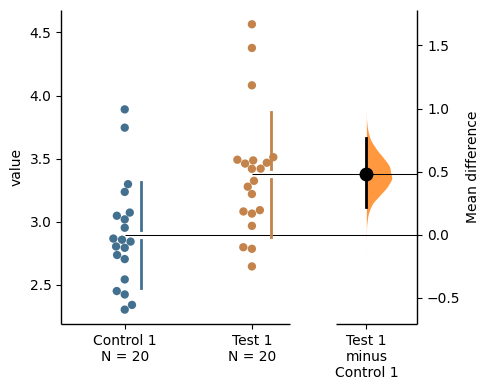

In [24]:
fig1 = my_data.mean_diff.plot();

 Create a Gardner-Altman plot for the Hedges' g effect size.

C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\dabest\plotter.py:473: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  rawdata_plot = sns.swarmplot(data=plot_data, x=xvar, y=yvar,
C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\dabest\plotter.py:563: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  rawdata_axes.set_xticklabels(ticks_with_counts)


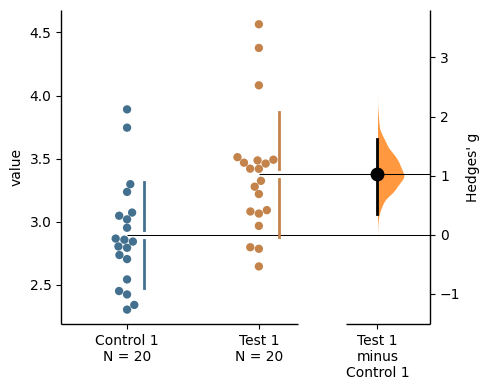

In [25]:
fig2 = my_data.hedges_g.plot();

Create a Cumming estimation plot for the mean difference.

C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\dabest\plotter.py:473: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  rawdata_plot = sns.swarmplot(data=plot_data, x=xvar, y=yvar,
C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\dabest\plotter.py:563: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  rawdata_axes.set_xticklabels(ticks_with_counts)


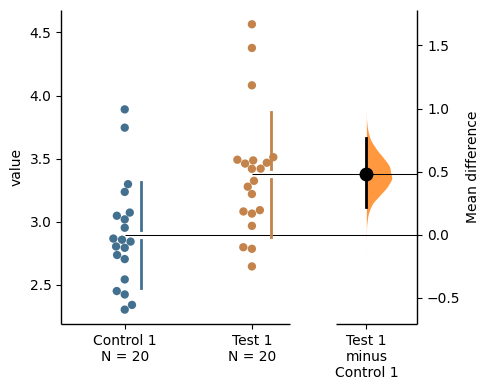

In [26]:
fig3 = my_data.mean_diff.plot(float_contrast=True);

 Create a paired Gardner-Altman plot.

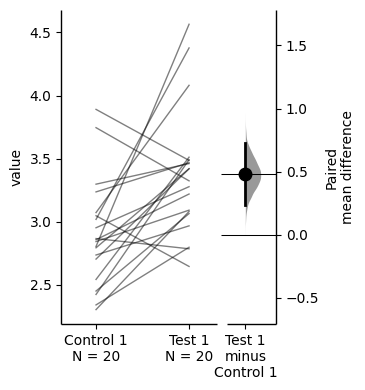

In [27]:
my_data_paired = dabest.load(df, idx=("Control 1", "Test 1"),
                       id_col = "ID", paired='baseline')
fig4 = my_data_paired.mean_diff.plot();

Create a multi-group Cumming plot.

C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\dabest\plotter.py:473: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  rawdata_plot = sns.swarmplot(data=plot_data, x=xvar, y=yvar,
C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\dabest\plotter.py:563: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  rawdata_axes.set_xticklabels(ticks_with_counts)


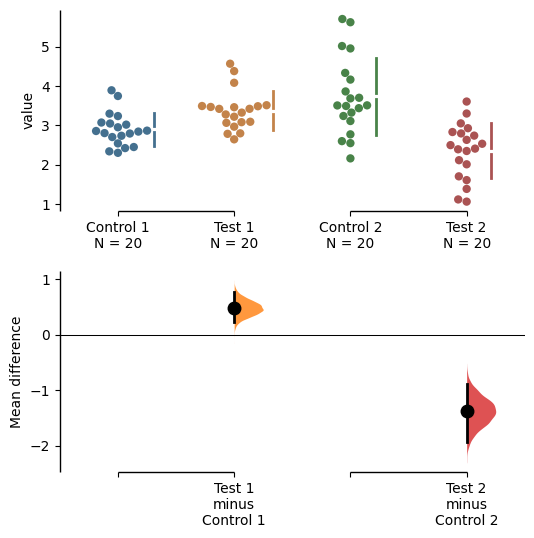

In [28]:
my_multi_groups = dabest.load(df, id_col = "ID", 
                             idx=(("Control 1", "Test 1"),
                                 ("Control 2", "Test 2")))
fig5 = my_multi_groups.mean_diff.plot();

Create a shared control Cumming plot.

C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\dabest\plotter.py:473: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  rawdata_plot = sns.swarmplot(data=plot_data, x=xvar, y=yvar,
C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\dabest\plotter.py:563: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  rawdata_axes.set_xticklabels(ticks_with_counts)


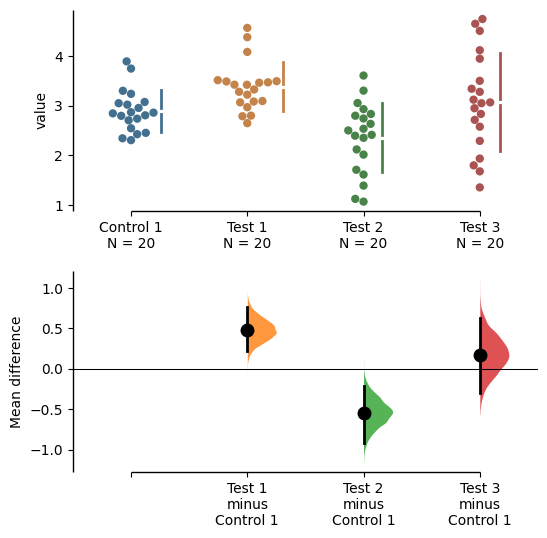

In [29]:
my_shared_control = dabest.load(df, id_col = "ID",
                                 idx=("Control 1", "Test 1",
                                          "Test 2", "Test 3"))
fig6 = my_shared_control.mean_diff.plot();

Create a repeated meausures (against baseline) Slopeplot.

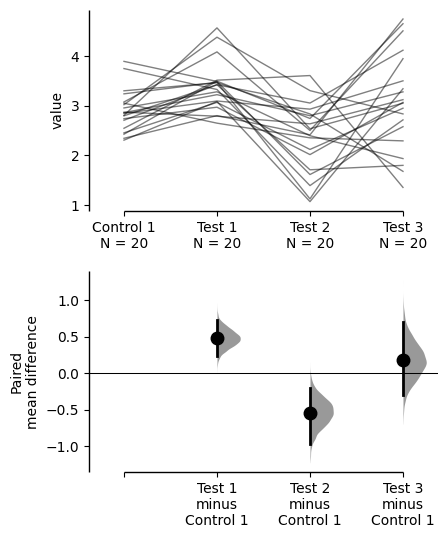

In [30]:
my_rm_baseline = dabest.load(df, id_col = "ID", paired = "baseline",
                                 idx=("Control 1", "Test 1",
                                          "Test 2", "Test 3"))
fig7 = my_rm_baseline.mean_diff.plot();

Create a repeated meausures (sequential) Slopeplot.

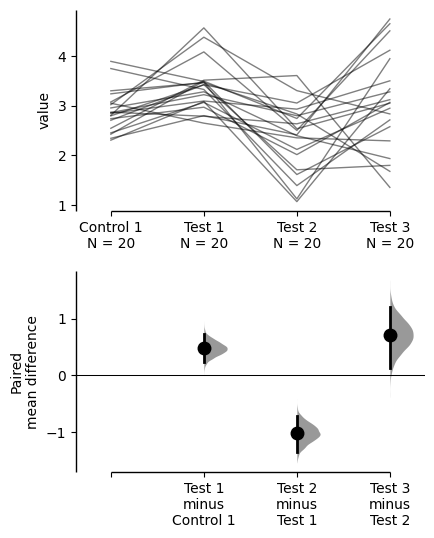

In [31]:
my_rm_sequential = dabest.load(df, id_col = "ID", paired = "sequential",
                                 idx=("Control 1", "Test 1",
                                          "Test 2", "Test 3"))
fig8 = my_rm_sequential.mean_diff.plot();

In [32]:
#| export
class PermutationTest:
    """
    A class to compute and report permutation tests.
    
    Parameters
    ----------
    control : array-like
    test : array-like
        These should be numerical iterables.
    effect_size : string.
        Any one of the following are accepted inputs:
        'mean_diff', 'median_diff', 'cohens_d', 'hedges_g', or 'cliffs_delta'
    is_paired : string, default None
    permutation_count : int, default 10000
        The number of permutations (reshuffles) to perform.
    random_seed : int, default 12345
        `random_seed` is used to seed the random number generator during
        bootstrap resampling. This ensures that the generated permutations
        are replicable.
        
    Returns
    -------
    A :py:class:`PermutationTest` object:
        `difference`:float
            The effect size of the difference between the control and the test.
        `effect_size`:string
            The type of effect size reported.
    
    
    """
    
    def __init__(self, control:np.array,
                 test:np.array, # These should be numerical iterables.
                 effect_size:str, # Any one of the following are accepted inputs: 'mean_diff', 'median_diff', 'cohens_d', 'hedges_g', or 'cliffs_delta'
                 is_paired:str=None,
                 permutation_count:int=5000, # The number of permutations (reshuffles) to perform.
                 random_seed:int=12345,#`random_seed` is used to seed the random number generator during bootstrap resampling. This ensures that the generated permutations are replicable.
                 **kwargs):
    
        import numpy as np
        from numpy.random import PCG64, RandomState
        from ._stats_tools.effsize import two_group_difference
        from ._stats_tools.confint_2group_diff import calculate_group_var
        

        self.__permutation_count = permutation_count

        # Run Sanity Check.
        if is_paired and len(control) != len(test):
            raise ValueError("The two arrays do not have the same length.")

        # Initialise random number generator.
        # rng = np.random.default_rng(seed=random_seed)
        rng = RandomState(PCG64(random_seed))

        # Set required constants and variables
        control = np.array(control)
        test = np.array(test)

        control_sample = control.copy()
        test_sample    = test.copy()

        BAG = np.array([*control, *test])
        CONTROL_LEN = int(len(control))
        EXTREME_COUNT = 0.
        THRESHOLD = np.abs(two_group_difference(control, test, 
                                                is_paired, effect_size))
        self.__permutations = []
        self.__permutations_var = []

        for i in range(int(permutation_count)):
            
            if is_paired:
                # Select which control-test pairs to swap.
                random_idx = rng.choice(CONTROL_LEN,
                                rng.randint(0, CONTROL_LEN+1),
                                replace=False)

                # Perform swap.
                for i in random_idx:
                    _placeholder      = control_sample[i]
                    control_sample[i] = test_sample[i]
                    test_sample[i]    = _placeholder
                
            else:
                # Shuffle the bag and assign to control and test groups.
                # NB. rng.shuffle didn't produce replicable results...
                shuffled = rng.permutation(BAG) 
                control_sample = shuffled[:CONTROL_LEN]
                test_sample    = shuffled[CONTROL_LEN:]


            es = two_group_difference(control_sample, test_sample, 
                                    False, effect_size)
            
            var = calculate_group_var(np.var(control_sample, ddof=1), 
                                      CONTROL_LEN, 
                                      np.var(test_sample, ddof=1), 
                                      len(test_sample))
            self.__permutations.append(es)
            self.__permutations_var.append(var)

            if np.abs(es) > THRESHOLD:
                EXTREME_COUNT += 1.

        self.__permutations = np.array(self.__permutations)
        self.__permutations_var = np.array(self.__permutations_var)

        self.pvalue = EXTREME_COUNT / permutation_count


    def __repr__(self):
        return("{} permutations were taken. The p-value is {}.".format(self.permutation_count, 
                                                                      self.pvalue))


    @property
    def permutation_count(self):
        """
        The number of permuations taken.
        """
        return self.__permutation_count


    @property
    def permutations(self):
        """
        The effect sizes of all the permutations in a list.
        """
        return self.__permutations

    
    @property
    def permutations_var(self):
        """
        The experiment group variance of all the permutations in a list.
        """
        return self.__permutations_var


**Notes**:
    
The basic concept of permutation tests is the same as that behind bootstrapping.
In an "exact" permutation test, all possible resuffles of the control and test 
labels are performed, and the proportion of effect sizes that equal or exceed 
the observed effect size is computed. This is the probability, under the null 
hypothesis of zero difference between test and control groups, of observing the
effect size: the p-value of the Student's t-test.

Exact permutation tests are impractical: computing the effect sizes for all reshuffles quickly exceeds trivial computational loads. A control group and a test group both with 10 observations each would have a total of  $20!$ or $2.43 \times {10}^{18}$ reshuffles.
Therefore, in practice, "approximate" permutation tests are performed, where a sufficient number of reshuffles are performed (5,000 or 10,000), from which the p-value is computed.

More information can be found [here](https://en.wikipedia.org/wiki/Resampling_(statistics)#Permutation_tests).


#### Example: permutation test

In [33]:
control = norm.rvs(loc=0, size=30, random_state=12345)
test = norm.rvs(loc=0.5, size=30, random_state=12345)
perm_test = dabest.PermutationTest(control, test, 
                                   effect_size="mean_diff", 
                                   is_paired=None)
perm_test

5000 permutations were taken. The p-value is 0.0758.